# EDA a partir de la API de MELI
### Parte II: algoritmo predictivo
<a id="top"></a>
Autor: Mathiews Flores Zavala

<p> En esta notebook, voy a explorar los resultados de las publicaciones de MELI meduante su API de acceso público, que se vio en la Parte I (ver en el<a href = 'https://github.com/Mattzvl/EDA_API_ML'> EDA_API_MELI </a> para mas detalles).</p>
<p><strong>Objetivo:</strong> Implementar un algoritmo predictivo para poder predecir las unidades vendidas <i>sold_quantity</i></p>

## Tabla de Contenidos
1. <a href="#1">Data Wrangling</a>
* 1.1 <a href="#1.1">Importando librerías y datos</a>
* 1.2 <a href="#1.2">Exploramos el Data Set </a>
* 1.3 <a href="#1.3">Limpieza del data set: columnas, duplicados y valores NaN</a>
* 1.4 <a href="#1.4">Outliers</a>
* 1.5 <a href="#1.5">Visualización</a>
* 1.6 <a href="#1.6">Feature Engineering</a>
* 1.7 <a href="#1.6">Feature Selection</a>

2. <a href="#2">Preproceso de datos</a>
* 2.1 <a href='#2.1'>Preparacion de los datos</a>
* 2.2 <a href='#2.2'>Separación de datos en Train y Test</a>
* 2.3 <a href='#2.3'> Vectorizamos con Tf_idf</a>
* 2.4 <a href='#2.4'>Encoding de variables categóricas</a>
* 2.5 <a href='#2.5'>Standarización de variables numéricas</a>
* 2.6 <a href='#2.6'>Features de Train y Test</a>

3. <a href="#3">Modelos de Predicción</a>
* 3.1 <a href='#3.1'>Stats Model</a>
    * 3.1.1 <a href='#3.1.1'>Regresión Lineal</a> 
    * 3.1.2 <a href='#3.1.2'>Regresión Lineal con Feature Selection</a> 
    * 3.1.3 <a href='#3.1.3'>VIF</a> 
    * 3.1.4 <a href='#3.1.4'>RFE</a> 
* 3.2 <a href='#3.2'>CatBoost</a>

4. <a href="#4">Conclusiones</a>



---
<a href="#top">Back to Index</a>
<a id="1"></a>
### 1) Data Wrangling
<a id="1.1"></a>
#### 1.1) Importando librerias y datos

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from time import time, sleep
import re

import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
import unidecode
from nltk.corpus import stopwords 


# Librerias de Machine Learning
from sklearn import preprocessing, metrics, linear_model
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor

Consulto la API de Mercado Libre publica mediante búsquedas. En esta instacia me focalizaré en recopilar datos para componer una muestra de la población de publicaciones disponibles de la API de MELI

In [2]:
data = pd.read_csv('./data/data_part1.csv')
data.head()

,id,site_id,title,price,prices,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,...,neutral,claims,delayed_handling_time,sales,cancellations,free_shipping,mode,tags.2,logistic_type,store_pick_up
0,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,75999.0,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",NaN,ARS,169,7505,buy_it_now,...,0.01,"{'rate': 0.0087, 'value': 1095, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 120415}","{'rate': 0, 'value': 1, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
1,MLA926081002,MLA,Smart Tv Bgh 50 4k Uhd Android,62999.0,"{'id': 'MLA926081002', 'prices': [{'id': '45',...",NaN,ARS,250,250,buy_it_now,...,0.01,"{'rate': 0.0087, 'value': 1095, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 120415}","{'rate': 0, 'value': 1, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
2,MLA935211923,MLA,Smart Tv Hyundai Hyled-50uhd5a 4k 50 220v,69999.0,"{'id': 'MLA935211923', 'prices': [{'id': '1', ...",NaN,ARS,350,5,buy_it_now,...,0.01,"{'rate': 0.0087, 'value': 1095, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 120415}","{'rate': 0, 'value': 1, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
3,MLA884683677,MLA,Smart Tv Samsung 50 4k Uhd 50tu7000,75999.0,"{'id': 'MLA884683677', 'prices': [{'id': '154'...",NaN,ARS,150,500,buy_it_now,...,0.01,"{'rate': 0.0087, 'value': 1095, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 120415}","{'rate': 0, 'value': 1, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
4,MLA878666563,MLA,Smart Tv Philips 6600 Series 50pud6654/77 Led ...,62999.0,"{'id': 'MLA878666563', 'prices': [{'id': '221'...",NaN,ARS,567,2430,buy_it_now,...,0.01,"{'rate': 0.0087, 'value': 1095, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 120415}","{'rate': 0, 'value': 1, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False


In [3]:
data.shape

(4165, 63)

La busqueda mediante la API de MELI se obtuvo un data set con 4160 registros focalizado principalmente elementos de eletronica como lo son televisores, telefonos, notebooks, tablets.

<a id="1.2"></a>
#### 1.2) Explorando el data set

In [4]:
# explioramos el data set de la parte 1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165 entries, 0 to 4164
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4165 non-null   object 
 1   site_id                4165 non-null   object 
 2   title                  4165 non-null   object 
 3   price                  4165 non-null   float64
 4   prices                 4165 non-null   object 
 5   sale_price             0 non-null      float64
 6   currency_id            4165 non-null   object 
 7   available_quantity     4165 non-null   int64  
 8   sold_quantity          4165 non-null   int64  
 9   buying_mode            4165 non-null   object 
 10  listing_type_id        4165 non-null   object 
 11  stop_time              4165 non-null   object 
 12  condition              4165 non-null   object 
 13  permalink              4165 non-null   object 
 14  thumbnail              4165 non-null   object 
 15  thum

In [5]:
# veamos los valores númericos para conocer su comportamiento
data.describe()

,price,sale_price,available_quantity,sold_quantity,original_price,official_store_id,order_backend,id.1,total,canceled,completed,negative,positive,neutral
count,4.165000e+03,0.0,4165.000000,4165.000000,545.000000,669.000000,4165.000000,4.165000e+03,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000,4165.000000
mean,7.543591e+04,NaN,137.558223,45.366387,71934.556147,962.116592,25.485954,2.042866e+08,48624.053301,2605.080912,46018.972389,0.027712,0.949008,0.021839
std,3.693016e+05,NaN,1451.521984,269.747362,60110.166556,817.399770,14.426887,1.668899e+08,108306.954437,5297.685890,103067.481918,0.045328,0.089999,0.069635
min,3.300000e+01,NaN,1.000000,0.000000,1599.990000,47.000000,1.000000,1.048590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.600000e+04,NaN,1.000000,1.000000,19999.000000,229.000000,13.000000,8.252185e+07,3278.000000,179.000000,3062.000000,0.010000,0.940000,0.010000
50%,5.297900e+04,NaN,1.000000,5.000000,61590.000000,945.000000,25.000000,1.699493e+08,13504.000000,970.000000,12180.000000,0.020000,0.960000,0.020000
75%,9.597500e+04,NaN,5.000000,25.000000,109999.000000,1550.000000,38.000000,2.797363e+08,36658.000000,2216.000000,34178.000000,0.030000,0.980000,0.020000
max,2.335000e+07,NaN,50000.000000,11030.000000,334999.000000,2549.000000,50.000000,7.998410e+08,637704.000000,29475.000000,608229.000000,1.000000,1.000000,1.000000


En esta priemra instancia podemos observar que cirtos valores como *id.1, official_store_id, order_backend* no aportaran peso al modelo.
Por otro lado la columna *sale_price* se encuentra vacia.

 <a id="1.3"></a>
#### 1.3) Limpieza del data set: columnas, duplicados y valores NaN
En esta instancia se tratarán las columnas, valores duplicados y nulos.
Además, determinar que registros se conservarán (feature selection)

In [6]:
# eliminamos las columnas que consideramos no nos aportarán al modelo
data_clean = data.drop(['id.1', 'official_store_id', 'order_backend'],axis =1)

In [7]:
# conozco las columnas que posee y para referencia
columnas_ref =data_clean.columns

# exploro cuales son aquellas columnas que contienen id en su nombre y que pueden ser simplemente primaries o foreign keys
indices_col_ref = [pos for pos, element in enumerate(columnas_ref) if 'id' in element]
columnas_ref[indices_col_ref]

Index(['id', 'site_id', 'currency_id', 'listing_type_id', 'thumbnail_id',
       'category_id', 'domain_id', 'catalog_product_id', 'use_thumbnail_id',
       'state_id', 'city_id', 'level_id'],
      dtype='object')

In [8]:
# veamos el data set que contiene solamente columnas con la palabra id
data_clean[columnas_ref[indices_col_ref]]

,id,site_id,currency_id,listing_type_id,thumbnail_id,category_id,domain_id,catalog_product_id,use_thumbnail_id,state_id,city_id,level_id
0,MLA898844422,MLA,ARS,gold_pro,878604-MLA44160072739_112020,MLA1002,MLA-TELEVISIONS,MLA16233171,True,AR-B,NaN,5_green
1,MLA926081002,MLA,ARS,gold_pro,893006-MLA46430431526_062021,MLA1002,MLA-TELEVISIONS,NaN,True,AR-B,NaN,5_green
2,MLA935211923,MLA,ARS,gold_pro,967879-MLA47132963322_082021,MLA1002,MLA-TELEVISIONS,MLA17849007,True,AR-B,NaN,5_green
3,MLA884683677,MLA,ARS,gold_pro,787429-MLA43816255167_102020,MLA1002,MLA-TELEVISIONS,MLA16233171,True,AR-B,NaN,5_green
4,MLA878666563,MLA,ARS,gold_pro,826710-MLA42164194325_062020,MLA1002,MLA-TELEVISIONS,MLA15699007,True,AR-B,NaN,5_green
...,...,...,...,...,...,...,...,...,...,...,...,...
4160,MLA865478239,MLA,ARS,gold_special,714893-MLA44038990499_112020,MLA1652,MLA-NOTEBOOKS,MLA16029705,False,AR-C,TUxBQlZJTDcwOTla,5_green
4161,MLA901539489,MLA,ARS,gold_pro,867201-MLA44367000452_122020,MLA1652,MLA-NOTEBOOKS,MLA17512115,False,AR-B,NaN,5_green
4162,MLA910513713,MLA,ARS,gold_pro,914329-MLA45088615993_032021,MLA1652,MLA-NOTEBOOKS,MLA16189142,False,AR-C,TUxBQlZJTDcwOTla,5_green
4163,MLA909819728,MLA,ARS,gold_special,983950-MLA45013944220_022021,MLA1652,MLA-NOTEBOOKS,NaN,False,AR-C,TUxBQlZJTDQyMjBa,5_green


In [9]:
def cant_valores_unicos(df):
    '''Cuenta la cantidad de valores unicos que existen cada columna de un dataset y devuelve un diccionario'''
    columnas = df.columns
    rta = {}
    for col in columnas:
        rta[col] = len(df[col].value_counts())
    return rta

In [10]:
cant_valores_unicos( data_clean[columnas_ref[indices_col_ref]] )

{'id': 4164,
 'site_id': 1,
 'currency_id': 1,
 'listing_type_id': 2,
 'thumbnail_id': 3432,
 'category_id': 16,
 'domain_id': 13,
 'catalog_product_id': 1221,
 'use_thumbnail_id': 2,
 'state_id': 20,
 'city_id': 101,
 'level_id': 4}

Como se puede observar, solo hay valores únicos para *site_id, currency_id* por lo tanto dropeare estos ya que no aportaran sustancialmente algo al modelo. Esto tiene sentido ya que los valores de las busquedas a la API se realizaron mediante el sitio MLA, por consiguiente la moneda predominante debería ser PESOS ARS.

In [11]:
data_clean = data_clean.drop(['site_id', 'currency_id'],axis =1)

Ocurre algo similar con *state_id, city_id* donde al ya tener *state_name, y city_name* estas resultan redundantes para el análisis. Así que tambien serán dropeadas.

In [12]:
data_clean = data_clean.drop(['state_id', 'city_id'],axis =1)

Tratamiento de valores duplicados, existen valores duplicados? es decir que contengan exactamente la misma data en sus registros.

In [13]:
# tratamiento de duplicados
print('Hay {} registros duplicados'.format(data_clean.duplicated().sum() ))

# eliminamos los registros duplicados
data_clean.drop_duplicates(inplace = True, keep='last')

print('\nQuedan registros duplicados?', data.duplicated().any() )

Hay 1 registros duplicados

Quedan registros duplicados? False


Respecto de datos *id* de las publicaciones que actuarian como una llave para los registros. En este caso, la cantidad de registros únicos coincidecon la cantidad de registros duplicados.
Por otro lado, respecto de las miñiaturas *thumbnail_id, use_thumbnail_id* no serán incorporadas al modelo.

In [14]:
data_clean = data_clean.drop(['thumbnail_id', 'use_thumbnail_id'],axis =1)

La columna *category_id* esta estreñamente relacionada con *domain_id* por lo tanto mantendremos solamente *domain_id*, que se utilizó en una instancia anterior para poder analizar los datos por categorias.

In [15]:
data_clean = data_clean.drop(['category_id'],axis =1)

In [16]:
# volvamos a ver cuantas son las que columnas que conservamos
columnas_ref2 =data_clean.columns
indices_col_ref2 = [pos for pos, element in enumerate(columnas_ref2) if 'id' in element]
columnas_ref2[indices_col_ref2]

Index(['id', 'listing_type_id', 'domain_id', 'catalog_product_id', 'level_id'], dtype='object')

In [17]:
# level_id parece indicar, siendo redundante, el nivel donde verde es muy bueno y naranja no tan bueno, esto relacionado
# con la confiabilidad/reputacion del vendedor que se indica en el portal de mercado libre usando esta escala.
data_clean['level_id'].value_counts()

5_green          3967
3_yellow           73
2_orange           15
4_light_green      12
Name: level_id, dtype: int64

In [18]:
# veamos que pasa con listing_type, el tipo de cotizacion se puede ver que hay dos tipos de categoria
data_clean['listing_type_id'].value_counts()

gold_special    2860
gold_pro        1304
Name: listing_type_id, dtype: int64

Para esta instancia es claro denotar que hay información que puede ser redundante y a su vez equivalente a otras, la descripción de una publicación se conrresponde con el id, pero ofrece data que puede ser más sustancial.

Por otro lado, *catalog_product_id* es el producto que se publica, que puede ser común para varias publicaciones (estan correlacionadas)

In [19]:
data_clean = data_clean.drop(['catalog_product_id'],axis =1)

Concentremonos en los **valores nulos** que tenemos, como se vio anteriormente *sale_price* es la única columna con todos sus registros nulos.

In [20]:
data_clean = data_clean.drop(['sale_price'],axis =1)

<a id="1.4"></a>
#### 1.4) Eliminación de Outliers

En esta instancia se eliminaran ciertos outliers que pueden hacer ruido en el modelo, principalmente aquellos vistos en la Parte I (ver en el<a href = 'https://github.com/Mattzvl/EDA_API_ML'> EDA_API_MELI </a> para mas detalles).</p> En este caso se empezará por el precio

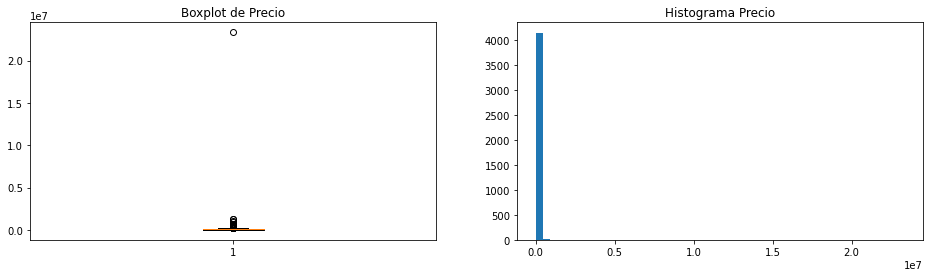

In [21]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
plt.boxplot(data=data_clean, x='price')
plt.title('Boxplot de Precio');

ax = plt.subplot(1,2,2)
plt.hist(data=data_clean, x='price', bins=50)
plt.title('Histograma Precio');

La forma del histograma hace recordar a los vistos en la parte 1, en particular para Tables y Televisores

In [22]:
# quitamos las  filas con distancias mayores a 1.5 + IQR
Q1_d, Q3_d = np.percentile(data_clean['price'], [25, 75])
IQR_d = Q3_d-Q1_d
lower_bound_d = Q1_d - (1.5 * IQR_d)
upper_bound_d = Q3_d + (1.5 * IQR_d)
# outlier_index = np.where((x < lower_bound) | (x > upper_bound))

# nos quedamos con las aquellos precios originales menores al quartil 3
data_clean2 = data_clean.loc[data_clean['price'] < upper_bound_d]

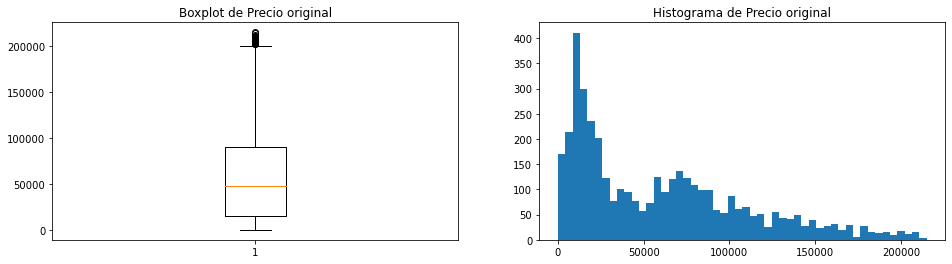

In [23]:
# veamos como resulto leugo de la eliminación de outlies
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
plt.boxplot(data=data_clean2, x='price')
plt.title('Boxplot de Precio original');

ax = plt.subplot(1,2,2)
plt.hist(data=data_clean2, x='price', bins=50)
plt.title('Histograma de Precio original');

Luego de la eliminación de Outliers se puede apreciar una distribución normal segada por la derecha, si bien siguen quedando algunos valores que estan algo por encima fuera del boxplot, los conservaremos apra el modelo.

<a id="1.5"></a>
#### 1.5) Visualizacion de datos

In [24]:
(data_clean2.groupby('domain_id')['original_price'].agg(['mean','median','std','max','min']).round(2)).sort_values(by = 'mean', ascending=False)

,mean,median,std,max,min
domain_id,,,,,
MLA-NOTEBOOKS,121653.05,116671.50,49463.52,274999.00,44589.09
MLA-TELEVISIONS,92175.09,79999.00,32639.00,211199.00,49999.00
MLA-CELLPHONES,28115.37,25999.00,16377.91,79999.00,4839.00
MLA-TABLETS,21794.62,16799.00,13060.11,62999.00,7279.09
MLA-TV_RECEIVERS_AND_DECODERS,14000.00,14000.00,NaN,14000.00,14000.00
MLA-STREAMING_MEDIA_DEVICES,12688.90,12549.00,2463.88,16549.00,8507.59
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,2162.62,2407.89,488.59,2479.99,1599.99
MLA-TV_AND_MONITOR_MOUNTS,1899.99,1899.99,NaN,1899.99,1899.99
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS,NaN,NaN,NaN,NaN,NaN


Las notebooks representan aquellos productos que tienen el mayor precio promedio (independientemente de la gama del articulo)
En tanto que las tablets tienen el menor precio medio.

Los valores máx quedaron mucho más coherentes, aunque hay casos donde el min de television, telefonos y tablet que son casi 2500 veces menores a la media, del orden de 1e-4.

Aquellos que tienen std = NaN, son aquellos elementos que son unicos, ya que temino dividinedo por 0 (n-1).
Estos son productos que se colaron el la busqueda de television, donde los resultados entregados no fueron tan precisos como con tablets, notebooks y celulares.

domain_id = ['MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS', 'MLA-TV_RECEIVERS_AND_DECODERS', 'MLA-TV_REMOTE_CONTROL_COVERS']

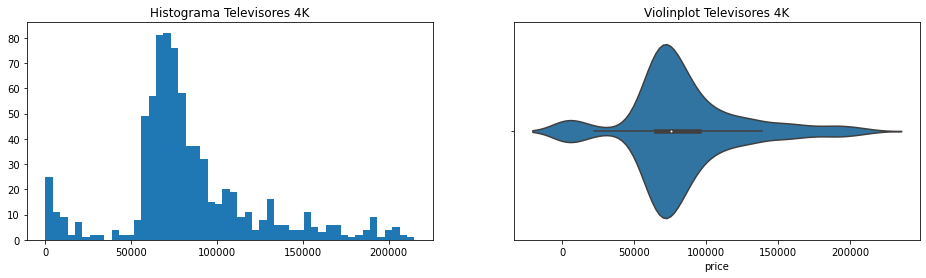

In [25]:
plt.figure(figsize = (16, 4))

ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-TELEVISIONS']
plt.hist(data=data_2plot, x='price', bins=50)
plt.title('Histograma Televisores 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10)
plt.title('Violinplot Televisores 4K')
plt.show()

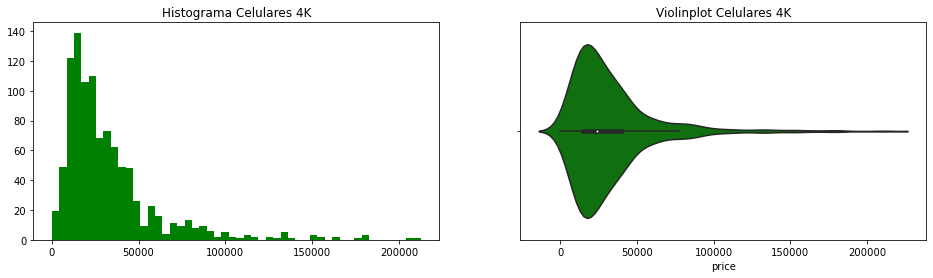

In [26]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-CELLPHONES']
plt.hist(data=data_2plot, x='price', bins=50, color= 'green')
plt.title('Histograma Celulares 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10, color= 'green')
plt.title('Violinplot Celulares 4K')
plt.show()

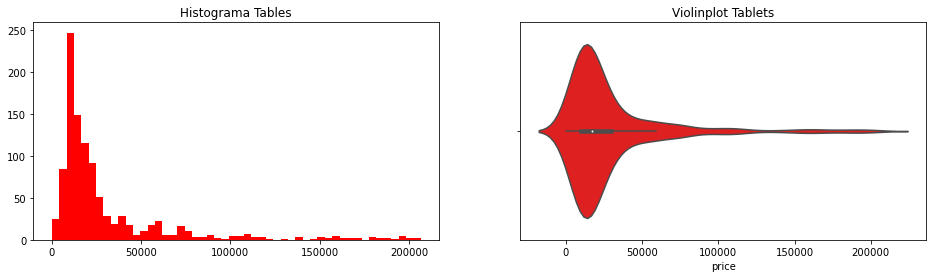

In [27]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-TABLETS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Histograma Tables')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Violinplot Tablets')
plt.show()

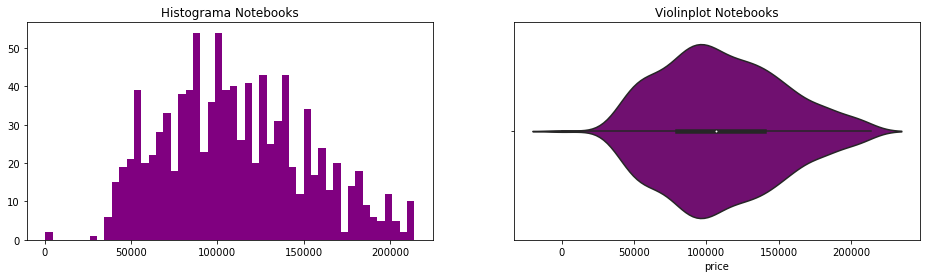

In [28]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-NOTEBOOKS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Histograma Notebooks')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Violinplot Notebooks')
plt.show()

Los histogramas parecen distribuciones normales, la mayoria segadas hacia la izquierda (precios más bajos) al menos en televisores, celulares y tablets.

Se observa que hay ciertos datos anómalos al menos en la zona televisores que forman otro pico en uno de los extremos de la distribución, esto podría deberse a productos que tengan relación estrecha con televiosres, como controles, accesorios, sin embargo recibieron se etiquetaron con el *domain_id* que le corresponde a los televisores.

#### Estudio de correlaciones

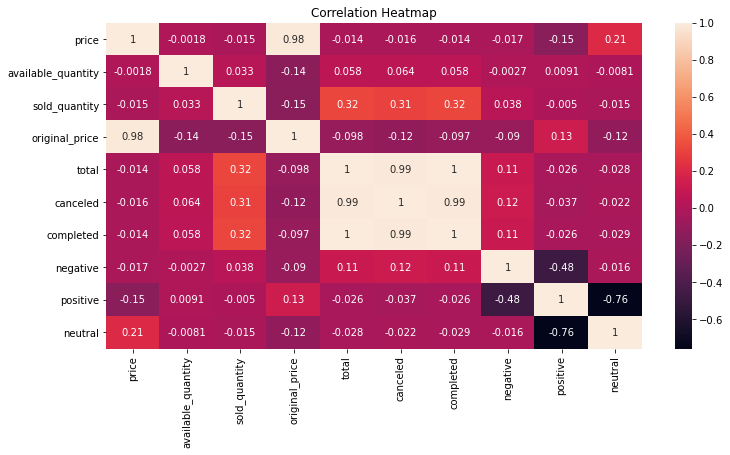

In [29]:
# graficamos un heatmap para exploras la relacion entre variables
plt.figure(figsize=(12,6))
# para no incorporar solamente aquellas variables numericas, ya que de lo contrario me tomaria los buleanos 
num_cols = [x for x in data_clean2.select_dtypes(include=['number']).columns]
sns.heatmap(data_clean[num_cols].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

De lo observado en el heat map, se puede ver que *sold_quantity* tiene relación poca correlación varios campos, la relación negativa de unidades vendidas con el precio, nos indicaría a priori que a mayor precio menos unidades vendidas.

Los aportes de cantidad de pedidos *total, canceled, completes* tienen practicamente el mismo aporte. Luego el rate *negative, positive, neutral* tienen un aporte cercano al cero. Lo mismo con *aviable_quantity*.

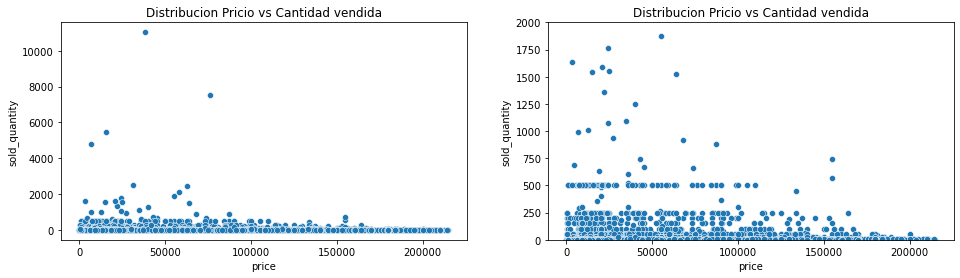

In [30]:
#Correlación entre cantidades vendidas y el precio
plt.figure(figsize = (16, 4))
data2plot1 = data_clean2.loc[:,['sold_quantity','price',]].copy()
ax = plt.subplot(1,2,1)
sns.scatterplot(data= data2plot1 ,x='price',y='sold_quantity')
plt.title('Distribucion Pricio vs Cantidad vendida');

ax = plt.subplot(1,2,2)
sns.scatterplot(data= data2plot1 ,x='price',y='sold_quantity')
plt.ylim(0, 2000)
plt.title('Distribucion Pricio vs Cantidad vendida');

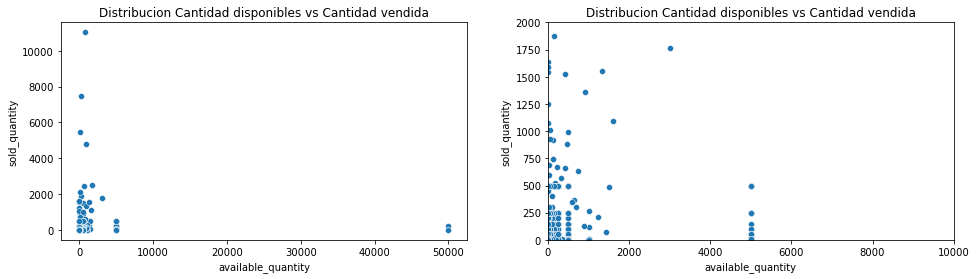

In [31]:
#Correlación entre cantidades vendidas y el precio
plt.figure(figsize = (16, 4))
data2plot1 = data_clean2.loc[:,['sold_quantity','available_quantity',]].copy()
ax = plt.subplot(1,2,1)
sns.scatterplot(data= data2plot1 ,x='available_quantity',y='sold_quantity')
plt.title('Distribucion Cantidad disponibles vs Cantidad vendida');

ax = plt.subplot(1,2,2)
sns.scatterplot(data= data2plot1 ,x='available_quantity',y='sold_quantity')
plt.ylim(0, 2000)
plt.xlim(0, 10000)
plt.title('Distribucion Cantidad disponibles vs Cantidad vendida');

<a id="1.6"></a>
#### 1.6) Feature Engineering

Respecto de los valores **nulos** de la columna *original_price*, aquellos registros con valores *nulls* corresponden a valores donde se aplica un descuento. Al ser *original_price* correlativa a *price*, voy a conservar price, sin embargo se generará un nuevo campo que represente el % de descuento.

In [32]:
data_clean2[['price','original_price']].sample(7)

,price,original_price
2293,10339.0,NaN
3173,43849.0,NaN
1193,44999.0,NaN
1959,39990.0,46500.0
2980,42999.0,NaN
1092,21899.0,NaN
2508,9949.0,NaN


In [33]:
# completo los datos nulo de original_price con los valores de price
data_clean2['original_price'].fillna(data_clean2['price'], inplace = True)
#y verifico por si acaso
data_clean2['original_price'].isnull().sum()

0

In [34]:
# chequeo que no haya ningun valor de precio con valores = 0, es decir, Free!
data_clean2[data_clean2['original_price'] == 0]

,id,title,price,prices,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,...,neutral,claims,delayed_handling_time,sales,cancellations,free_shipping,mode,tags.2,logistic_type,store_pick_up


In [35]:
# creo una nueva columna donde indico el valor del descuento que se aplica en la publciacion
data_clean2['discount'] = 1 - data_clean2['price']/data_clean2['original_price']

Mas alla del ranking del usuario, la cantidad de ventas concretadas nos da una razon porcentual del éxito de sus ventas, aunque claro esta existen otros factores que también influyen en que no se concrete una venta.

Vamos a crear el *ranking_success* a partir de *completed / total*.

In [36]:
data_clean2['ranking_success'] = np.where(data_clean2['total']!= 0, data_clean2['completed']/data_clean2['total'], 0)

Datos unicos? para no tener un data set desbalanceado voy a eliminar aquellos casos donde solo haya un registro. Ya que hacer upper sampling implicaría simplemente en duplicar los registros únicos para las categorías de *domain_id*
donde solo tengo un valor.

In [37]:
# tipos de dominios, para identificar si la busqueda me devolvio efectivamente los cambos de las busquedas
data_clean2.domain_id.value_counts()

MLA-TABLETS                                   1028
MLA-CELLPHONES                                1016
MLA-NOTEBOOKS                                  998
MLA-TELEVISIONS                                782
MLA-STREAMING_MEDIA_DEVICES                     85
MLA-TV_REMOTE_CONTROLS                          51
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS         38
MLA-TV_AND_MONITOR_MOUNTS                       10
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS       3
MLA-TV_RECEIVERS_AND_DECODERS                    1
MLA-STREAMING_MEDIA_PLAYER_REMOTE_CONTROLS       1
MLA-ELECTRONIC_PRODUCTS                          1
MLA-TV_REMOTE_CONTROL_COVERS                     1
Name: domain_id, dtype: int64

In [38]:
# tiramos aquellas clases de productos que aparezcan  menos de 2 veces
def remove_lonely_reg(data_reg, columna):
    '''Funcion que remueve registros que aparezcan  menos de 2 veces
    Se entrega un data set y la columna de interes, y se devuelve un data set'''
    return data_reg[~data_reg[columna].isin(data_reg[columna].value_counts().loc[lambda x: x < 3].index)]

data_clean3 = remove_lonely_reg(data_clean2, 'domain_id')
data_clean3.domain_id.value_counts()

MLA-TABLETS                                   1028
MLA-CELLPHONES                                1016
MLA-NOTEBOOKS                                  998
MLA-TELEVISIONS                                782
MLA-STREAMING_MEDIA_DEVICES                     85
MLA-TV_REMOTE_CONTROLS                          51
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS         38
MLA-TV_AND_MONITOR_MOUNTS                       10
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS       3
Name: domain_id, dtype: int64

<a id="1.7"></a>
#### 1.7) Feature Selection

En esta instancia como continuacion de la limpieza, en lugar de dropear columnas que no considerare para el modelo, seleccionare aquellas que pasare al modelo final

In [39]:
data_clean3.to_excel('./data/data_clean3.xlsx', index= False)

In [40]:
data_clean3.columns

Index(['id', 'title', 'price', 'prices', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink',
       'thumbnail', 'accepts_mercadopago', 'installments', 'shipping',
       'seller_address', 'attributes', 'differential_pricing',
       'original_price', 'domain_id', 'tags', 'catalog_listing', 'permalink.1',
       'registration_date', 'car_dealer', 'real_estate_agency', 'tags.1',
       'seller_reputation', 'eshop', 'state_name', 'city_name',
       'power_seller_status', 'level_id', 'protection_end_date', 'real_level',
       'total', 'canceled', 'period', 'completed', 'negative', 'positive',
       'neutral', 'claims', 'delayed_handling_time', 'sales', 'cancellations',
       'free_shipping', 'mode', 'tags.2', 'logistic_type', 'store_pick_up',
       'discount', 'ranking_success'],
      dtype='object')

* *buying_mode* buy_it_now es el unico valor
* *accepts_mercadopago* VERDADERO es el unico valor
* *car_dealer* FALSO es el unico valor
* *real_estate_agency* FALSO es el unico valor
* *negative, positive, neutral* las 3 suman 1 por lo tanto solo podria considerar 2

In [41]:
data_m = data_clean3[['price','discount','available_quantity', 'sold_quantity','listing_type_id', 'condition','domain_id',\
                     'tags','state_name','city_name','power_seller_status','level_id','ranking_success',\
                      #'registration_date',\
                      'negative','positive','free_shipping','store_pick_up',   #]]
                      'id']]
data_m

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up,id
0,75999.0,0.0,169,7505,gold_pro,new,MLA-TELEVISIONS,"['extended_warranty_eligible', 'good_quality_p...",Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA898844422
1,62999.0,0.0,250,250,gold_pro,new,MLA-TELEVISIONS,"['catalog_product_candidate', 'extended_warran...",Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA926081002
2,69999.0,0.0,350,5,gold_pro,new,MLA-TELEVISIONS,"['ahora-24', 'extended_warranty_eligible', 'go...",Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA935211923
3,75999.0,0.0,150,500,gold_pro,new,MLA-TELEVISIONS,"['loyalty_discount_eligible', 'ahora-12', 'bra...",Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA884683677
4,62999.0,0.0,567,2430,gold_pro,new,MLA-TELEVISIONS,"['good_quality_picture', 'good_quality_thumbna...",Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA878666563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,90999.0,0.0,5000,5,gold_special,new,MLA-NOTEBOOKS,"['loyalty_discount_eligible', 'brand_verified'...",Capital Federal,Villa Urquiza,platinum,5_green,0.944394,0.03,0.95,True,False,MLA865478239
4161,94900.0,0.0,1,4,gold_pro,new,MLA-NOTEBOOKS,"['good_quality_thumbnail', 'loyalty_discount_e...",Buenos Aires,San Martin,platinum,5_green,0.949865,0.01,0.98,True,False,MLA901539489
4162,74999.0,0.0,5000,5,gold_pro,new,MLA-NOTEBOOKS,"['ahora-12', 'catalog_listing_eligible', 'exte...",Capital Federal,Villa Urquiza,platinum,5_green,0.944394,0.03,0.95,True,False,MLA910513713
4163,129995.0,0.0,1,5,gold_special,new,MLA-NOTEBOOKS,"['loyalty_discount_eligible', 'extended_warran...",Capital Federal,Villa Crespo,platinum,5_green,0.957548,0.01,0.97,True,False,MLA909819728


In [42]:
# creamos una serie de funciones de limpieza
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_simbols(text):
    return re.sub(r'[^\w]', ' ', text)

def remove_numbers(text):
    return re.sub('(\d+)','',text)

def remove_linear(text):
    return re.sub('(\_+)',' ',text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_simbols(text)
    text = remove_linear(text)
    text = remove_numbers(text)
    return text

In [43]:
# aplico al campo tags
data_m['tags']=data_m['tags'].apply(denoise_text)
data_m['tags']

0         extended warranty eligible    good quality p...
1         catalog product candidate    extended warran...
2         ahora     extended warranty eligible    good...
3         loyalty discount eligible    ahora     brand...
4         good quality picture    good quality thumbna...
                              ...                        
4160      loyalty discount eligible    brand verified ...
4161      good quality thumbnail    loyalty discount e...
4162      ahora     catalog listing eligible    extend...
4163      loyalty discount eligible    extended warran...
4164      extended warranty eligible    good quality p...
Name: tags, Length: 4011, dtype: object

In [44]:
# funcion que cuenta palabras clave en los tags de la publicacion
stop_words=stopwords.words('english') #la mayor parte de las palabras estan en ingles
vect=CountVectorizer(stop_words=stop_words,lowercase=True,strip_accents='unicode')

def words_freq(X):
    '''funcion que devuelve un dataframe con las palabras encontradas en un campo o serie y la cantidad que le corresponde'''
    X_enc=vect.fit_transform(X)    
    sum_words=X_enc.sum(axis=0)
    words_freq = sorted([(word, sum_words[0, idx]) for word, idx in  vect.vocabulary_.items()],reverse=False)
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    wf_df = pd.DataFrame(words_freq,columns=['word','quantity'])
        
    return wf_df

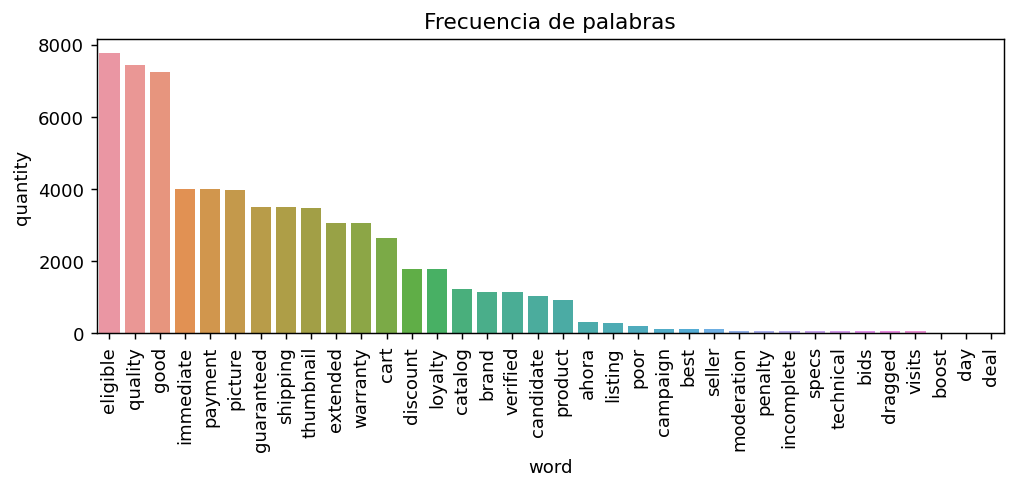

In [45]:
# Graficamos
words_cnt=words_freq(data_m.tags).head(75)
plt.figure(figsize=(9,3),dpi=130)
sns.barplot(data=words_cnt,x='word',y='quantity')
plt.title("Frecuencia de palabras")
plt.xticks(rotation=90);

In [46]:
words_cnt.head()

,word,quantity
0,eligible,7768
1,quality,7443
2,good,7245
3,immediate,4011
4,payment,4011


Como vemos las siguientes palabras son las *eligible, quality, good, immediate,	payment*

In [47]:
# token del metodo CountVectorizer
tokens=vect.get_feature_names()

In [48]:
# detecto palabras que no son reales, acorde al idioma que elegi
real_words=[]
wrong_words=[]
import enchant
from tqdm import tqdm 
spell=enchant.DictWithPWL("en_US")

for word in tqdm(tokens):
    if  spell.check(word):
        real_words.append(word)
    else:
        wrong_words.append(word)

stop_words_m = stopwords.words('english')
stop_words_m = text.ENGLISH_STOP_WORDS.union(wrong_words)

100%|█████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 605.50it/s]


In [49]:
print('Existe/n {} palabras que no son validas en ingles'.format(len(wrong_words)))
print('Existe/n {} palabras que son validas en el ingles'.format(len(real_words)))

Existe/n 1 palabras que no son validas en ingles
Existe/n 35 palabras que son validas en el ingles


In [50]:
print('La palabra que no reconoce es precisamente "{}"'.format(wrong_words[0]))

La palabra que no reconoce es precisamente "ahora"


La palabra que en los tags no corresponde debido al idioma elegido en la funcion anterior es "Ahora" que corresponde al tag: *Ahora-12*.

In [51]:
# me aseguro de no conservar datos nulos en los registros
data_m.dropna(inplace = True)

In [52]:
data_m

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up,id
0,75999.0,0.0,169,7505,gold_pro,new,MLA-TELEVISIONS,extended warranty eligible good quality p...,Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA898844422
1,62999.0,0.0,250,250,gold_pro,new,MLA-TELEVISIONS,catalog product candidate extended warran...,Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA926081002
2,69999.0,0.0,350,5,gold_pro,new,MLA-TELEVISIONS,ahora extended warranty eligible good...,Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA935211923
3,75999.0,0.0,150,500,gold_pro,new,MLA-TELEVISIONS,loyalty discount eligible ahora brand...,Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA884683677
4,62999.0,0.0,567,2430,gold_pro,new,MLA-TELEVISIONS,good quality picture good quality thumbna...,Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,True,False,MLA878666563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,90999.0,0.0,5000,5,gold_special,new,MLA-NOTEBOOKS,loyalty discount eligible brand verified ...,Capital Federal,Villa Urquiza,platinum,5_green,0.944394,0.03,0.95,True,False,MLA865478239
4161,94900.0,0.0,1,4,gold_pro,new,MLA-NOTEBOOKS,good quality thumbnail loyalty discount e...,Buenos Aires,San Martin,platinum,5_green,0.949865,0.01,0.98,True,False,MLA901539489
4162,74999.0,0.0,5000,5,gold_pro,new,MLA-NOTEBOOKS,ahora catalog listing eligible extend...,Capital Federal,Villa Urquiza,platinum,5_green,0.944394,0.03,0.95,True,False,MLA910513713
4163,129995.0,0.0,1,5,gold_special,new,MLA-NOTEBOOKS,loyalty discount eligible extended warran...,Capital Federal,Villa Crespo,platinum,5_green,0.957548,0.01,0.97,True,False,MLA909819728


In [53]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 4164
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                3382 non-null   float64
 1   discount             3382 non-null   float64
 2   available_quantity   3382 non-null   int64  
 3   sold_quantity        3382 non-null   int64  
 4   listing_type_id      3382 non-null   object 
 5   condition            3382 non-null   object 
 6   domain_id            3382 non-null   object 
 7   tags                 3382 non-null   object 
 8   state_name           3382 non-null   object 
 9   city_name            3382 non-null   object 
 10  power_seller_status  3382 non-null   object 
 11  level_id             3382 non-null   object 
 12  ranking_success      3382 non-null   float64
 13  negative             3382 non-null   float64
 14  positive             3382 non-null   float64
 15  free_shipping        3382 non-null   b

---
<a href="#top">Back to Index</a>
<a id="2"></a>
### 2) Preproceso de datos
<a id="2.1"></a>
#### 2.1) Preparacion de los datos

El data set obtenido de los *results* de la consulta existen ciertos campos que se han seleecionado para el analisis siendo *sold_quantity* la variable target. Debido a que tenemos varios tipos de datos voy a proceder a realizar ciertos cambios

In [54]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 4164
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                3382 non-null   float64
 1   discount             3382 non-null   float64
 2   available_quantity   3382 non-null   int64  
 3   sold_quantity        3382 non-null   int64  
 4   listing_type_id      3382 non-null   object 
 5   condition            3382 non-null   object 
 6   domain_id            3382 non-null   object 
 7   tags                 3382 non-null   object 
 8   state_name           3382 non-null   object 
 9   city_name            3382 non-null   object 
 10  power_seller_status  3382 non-null   object 
 11  level_id             3382 non-null   object 
 12  ranking_success      3382 non-null   float64
 13  negative             3382 non-null   float64
 14  positive             3382 non-null   float64
 15  free_shipping        3382 non-null   b

In [55]:
data_m['free_shipping']=data_m['free_shipping'].astype('category')
data_m['store_pick_up']=data_m['store_pick_up'].astype('category')

In [56]:
data_m['free_shipping']=data_m['free_shipping'].apply(lambda x: 1 if x == 'True' else 0)
data_m['store_pick_up']=data_m['store_pick_up'].apply(lambda x: 1 if x == 'True' else 0)

<a id="2.2"></a>
#### 2.2) Separación de datos en Train y Test

In [57]:
X=data_m[[x for x in data_m.columns if x !='sold_quantity']]
y=data_m['sold_quantity']

# split usando una relación de 80% de datos para train, y 20% datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Voy a identificar los tipos de datos que tengo en *numericos* y *categoricos*

In [58]:
# armo las listas de variables categorias y numericas
num_features = [x for x in X.select_dtypes(include=['number']).columns]
cat_features = [x for x in X.columns if x not in num_features]
print('Variables categoricas: %s' %cat_features)
print('--------------------------------------------------')
print('Variables numericas: %s' %num_features)

Variables categoricas: ['listing_type_id', 'condition', 'domain_id', 'tags', 'state_name', 'city_name', 'power_seller_status', 'level_id', 'id']
--------------------------------------------------
Variables numericas: ['price', 'discount', 'available_quantity', 'ranking_success', 'negative', 'positive', 'free_shipping', 'store_pick_up']


In [59]:
# remuevo 'id'
X_train.drop( ['id'], axis =1, inplace = True)
X_test.drop( ['id'], axis =1, inplace = True)
cat_features.remove('id')

In [60]:
# vamos a tener un tratamiento especial para tag
cat_features.remove('tags')
print('Variables categoricas: %s' %cat_features)

Variables categoricas: ['listing_type_id', 'condition', 'domain_id', 'state_name', 'city_name', 'power_seller_status', 'level_id']


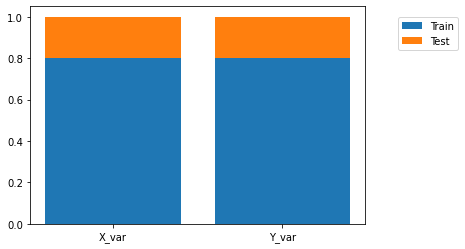

In [61]:
xplot = ['X_var','Y_var']
trainplot = [X_train.shape[0]/X.shape[0],y_train.shape[0]/y.shape[0]]
testplot = [X_test.shape[0]/X.shape[0],y_test.shape[0]/y.shape[0]]
fig, ax = plt.subplots()
ax.bar(xplot,trainplot,label = 'Train')
ax.bar(xplot,testplot,bottom = trainplot,label = 'Test')
ax.legend(loc = (1.1,0.8))

In [62]:
X_train.head()

,price,discount,available_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up
3141,43883.12,0.18,1,gold_pro,new,MLA-NOTEBOOKS,ahora extended warranty eligible good...,Capital Federal,Barracas,platinum,5_green,0.907612,0.05,0.93,0,0
3641,103900.00,0.00,1,gold_special,new,MLA-NOTEBOOKS,good quality picture good quality thumbna...,Capital Federal,Balvanera,platinum,5_green,0.918955,0.01,0.99,0,0
3337,169000.00,0.00,1,gold_special,new,MLA-NOTEBOOKS,good quality picture good quality thumbna...,Capital Federal,San Nicolás,platinum,5_green,0.958965,0.01,0.99,0,0
1016,68999.00,0.00,1,gold_special,new,MLA-TELEVISIONS,catalog product candidate extended warran...,Buenos Aires,Isidro Casanova,gold,5_green,0.941052,0.01,0.96,0,0
3818,175847.55,0.00,1,gold_special,new,MLA-NOTEBOOKS,brand verified catalog listing eligible ...,Capital Federal,CABA,platinum,5_green,0.950416,0.01,0.98,0,0


In [63]:
X_train.shape

(2705, 16)

<a id="2.3"></a>
#### 2.4) Vectorizamos con Tf_idf

In [64]:
# stop_words=stop_words_m  no voy a sacar el ahora 12
vectorizer=TfidfVectorizer(lowercase=True,strip_accents='unicode',max_df=0.7)
vectorizer.fit(X_train['tags'])

TfidfVectorizer(max_df=0.7, strip_accents='unicode')

In [65]:
X_train_tags = pd.DataFrame(vectorizer.transform(X_train['tags']).todense() )
X_test_tags = pd.DataFrame(vectorizer.transform(X_test['tags']).todense() )

In [66]:
# tengo que dropear 'tags' y resetear los indices
X_train.drop(['tags'],axis =1, inplace = True)
X_test.drop(['tags'],axis =1, inplace = True)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [67]:
# tambien lo aplico  a y
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

<a id="2.4"></a>
#### 2.4 Encoding de variables categóricas
Vamos a tratar las variables categoricas usando la libreria de *OneHotEncoder*

In [68]:
# con OneHotEncoder creamos variables dummies para place_name
onehot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

#X train enconded
X_ohe_train = onehot_encoder.fit_transform(X_train[cat_features])
X_ohe_train = pd.DataFrame(X_ohe_train, columns = onehot_encoder.get_feature_names(cat_features))

#X test enconded
X_ohe_test = onehot_encoder.transform(X_test[cat_features])
X_ohe_test = pd.DataFrame(X_ohe_test, columns = onehot_encoder.get_feature_names(cat_features))

<a id="2.5"></a>
#### 2.5 Standarización de variables numéricas
Vamos a tratar las variables numericas, usando *MinMaxScaler* para hacer la normalizacion

In [69]:
# normalization of X_train
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train[num_features])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)


# normalization of X_test
X_test_scaled = min_max_scaler.transform(X_test[num_features])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)

<a id="2.6"></a>
#### 2.6 Features de Train y Test

Finalmente vamos unificar lo trabajado hasta el momento para crear los set de train y test para el modelo

In [70]:
print('Sizes de los distintos datasets de entrenamiento y testeo')
print('Train Tags Vectorizado: ',X_train_tags.shape)
print('Train Tags Vectorizado: ', X_test_tags.shape)
print('--------------------------------------------------')
print('Train OHE: ' ,X_ohe_train.shape)
print('Test OHE: ', X_ohe_test.shape)
print('--------------------------------------------------')
print('Train Scaled: ',X_train_scaled.shape)
print('Test Scaled: ', X_test_scaled.shape)

Sizes de los distintos datasets de entrenamiento y testeo
Train Tags Vectorizado:  (2705, 28)
Train Tags Vectorizado:  (677, 28)
--------------------------------------------------
Train OHE:  (2705, 210)
Test OHE:  (677, 210)
--------------------------------------------------
Train Scaled:  (2705, 8)
Test Scaled:  (677, 8)


In [71]:
# concatenamos los datasets obtenidos hasta el momento
X_train = pd.concat([X_train_scaled, X_ohe_train , X_train_tags], axis = 1)
X_test = pd.concat([X_test_scaled, X_ohe_test, X_test_tags], axis = 1)

In [72]:
# luego de la unificacion
display(X_train.shape)
display(X_test.shape)

(2705, 246)

(677, 246)

In [73]:
display(y_train.shape)
display(y_test.shape)

(2705,)

(677,)

---
<a href="#top">Back to Index</a>
<a id="3"></a>
### 3) Modelos de Predicción


<a id="3.1"></a>
#### 3.1) Stats Model

<a id="3.1.1"></a>
##### 3.1.1) Regresión Lineal

Vamos a usar realizar una regresión lineal con Stats Model para poder analizar como se comportan las features del modelo.

In [74]:
# agregamos la columna para intercept
import statsmodels.api as sm  
X_train = sm.add_constant(X_train)

In [75]:
#fiteo el modelo
osl_m = sm.OLS(y_train,X_train,missing='drop').fit()

In [76]:
print(osl_m.summary())

                            OLS Regression Results                            
Dep. Variable:          sold_quantity   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     4.993
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           8.36e-89
Time:                        14:36:18   Log-Likelihood:                -17394.
No. Observations:                2705   AIC:                         3.522e+04
Df Residuals:                    2491   BIC:                         3.648e+04
Df Model:                         213                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [77]:
#Creo lista con las columnas eliminadas
feature_removed=[]
def p_value(X_train,y_train,alpha):
    
    feature_over_alpha_limit=1
        
    while feature_over_alpha_limit>0:
       
        #creo DF que contenga los features que Quedan en el modelo
        df=pd.DataFrame(columns=['Feature','P_Value'])
        feature_names=X_train.columns

        #fiteo el modelo
        osl_m = sm.OLS(y_train,X_train).fit()

        #Genero DF con P Values
        for i in range (0, X_train.shape[1]):
            p_values=(osl_m.pvalues[i]).round(3)
            df.loc[i]=[feature_names[i],p_values]

        #obtengo el maximo P_value del modelo
        Max_feature=df['P_Value'].idxmax()
        Max_P_value=df['P_Value'].max()

        #obtengo el feature a eliminar del modelo
        feature_to_exclude=df.loc[[Max_feature],['Feature']].iat[0,0]
        feature_removed.append(feature_to_exclude)

        #Elimino el feature del modelo
        X_train.drop(feature_to_exclude,axis=1,inplace=True)

        #obtener lista con cantidad de features con P value > 0.05
        feature_over_alpha_limit=len([x for x in df['P_Value'] if float(x) >=alpha])

    print("La cantidad de Features removidos es: ",feature_removed,"\nEl R2 es: ",osl_m.rsquared_adj.round(3))

Aplicamos la función **p_value** para remover aquellos features en donde su p_value es mayor a 0.05

In [78]:
# tengo un error con la key 28 ## a resolver
#p_value(X_train,y_train,0.05)

In [79]:
#feature_removed

<a id="3.1.2"></a>
##### 3.1.2) Regresión Lineal con Feature Selection

In [80]:
#fiteo el modelo
osl_m = sm.OLS(y_train,X_train).fit()
print(osl_m.summary())

                            OLS Regression Results                            
Dep. Variable:          sold_quantity   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     4.993
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           8.36e-89
Time:                        14:36:20   Log-Likelihood:                -17394.
No. Observations:                2705   AIC:                         3.522e+04
Df Residuals:                    2491   BIC:                         3.648e+04
Df Model:                         213                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [81]:
#Eliminamos los features que eliminamos en el training
X_test.drop(feature_removed,axis=1,inplace=True)

In [82]:
#agregamos la constante del modelo OLS
X_test = sm.add_constant(X_test)

In [83]:
#Fiteamos el modelo 
y_pred=osl_m.predict(X_test)

In [84]:
# Evaluamos el R2 usando Sklearn
r2_score(y_test, y_pred)

0.1217696747954018

<a id="3.1.3"></a>
##### 3.1.3) VIF (Variance Inflation Factor)

In [85]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.sort_values(by='VIF',ascending=False)
    return(vif)

In [86]:
calc_vif(X_train)

,variables,VIF
0,price,3.088117
1,discount,1.505415
2,available_quantity,1.506126
3,ranking_success,3.426469
4,negative,13.964958
...,...,...
241,23,inf
242,24,inf
243,25,inf
244,26,inf


<a id="3.1.4"></a>
##### 3.1.4) RFE (Feature Ranking with recursive elimination)

Documentación: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [87]:
#X_train.drop('const',axis=1,inplace=True)
#X_test.drop('const',axis=1,inplace=True)

In [88]:
# instanciamos y entrenamos el modelo
kf = KFold(n_splits=5, shuffle = True)
estimator = RandomForestRegressor()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'r2', verbose=2)
selector.fit(X_train, y_train)

Fitting estimator with 246 features.
Fitting estimator with 245 features.
Fitting estimator with 244 features.
Fitting estimator with 243 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
F

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 246 features.
Fitting estimator with 245 features.
Fitting estimator with 244 features.
Fitting estimator with 243 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 fea

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 fe

Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 fe

Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 fe

Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator wit

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=RandomForestRegressor(), scoring='r2', verbose=2)

In [89]:
selector

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=RandomForestRegressor(), scoring='r2', verbose=2)

In [90]:
X_train.loc[:,selector.support_].columns

Index([                       'price',                     'discount',
                 'available_quantity',              'ranking_success',
                           'negative',                     'positive',
           'listing_type_id_gold_pro', 'listing_type_id_gold_special',
                      'condition_new',               'condition_used',
       ...
                                   18,                             19,
                                   20,                             21,
                                   22,                             23,
                                   24,                             25,
                                   26,                             27],
      dtype='object', length=157)

In [91]:
scores = pd.DataFrame()
scores['Attribute Name'] = X_train.columns
scores['Ranking'] = selector.ranking_
scores['Support'] = selector.support_

display(scores.sort_values(by='Ranking',ascending=True))

,Attribute Name,Ranking,Support
0,price,1,True
139,city_name_Parque Chas,1,True
140,city_name_Parque Patricios,1,True
143,city_name_Piamonte,1,True
144,city_name_Piñeyro,1,True
...,...,...,...
103,city_name_La Boca,86,False
152,city_name_Ramos Mejia,87,False
74,city_name_Ciudad Madero,88,False
86,city_name_GRAL SAN MARTIN,89,False


In [92]:
scores[scores['Ranking']==1].sort_values(by='Ranking',ascending=True)

,Attribute Name,Ranking,Support
0,price,1,True
159,city_name_Rosario,1,True
161,city_name_SAN JUSTO,1,True
162,city_name_Saavedra,1,True
165,city_name_San Cristóbal,1,True
...,...,...,...
70,city_name_Chacarita,1,True
71,city_name_Ciudad Autonoma de Buenos Aires,1,True
72,city_name_Ciudad Autonoma de Buenos aires,1,True
65,city_name_Caballito,1,True


<a id="3.2"></a>
#### 3.2) CatBoost

CatBoost Tuneado

In [93]:
# Función para evaluar el rendimiento del modelo con los datos de Train
def evaluar_rendimiento(modelo, nombre, X, y, cv, scoring='r2'):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1, scoring=scoring)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))
    return s.mean()

In [94]:
# DataFrame para guardar el desempeño de los modelos
model_comparison = pd.DataFrame(columns = {'Model'})
# model_comparison

In [95]:
# Instanciamos Cross Validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [96]:
# Instanciamos el modelo que vamos a entrenar
model_cbr = CatBoostRegressor()
model_comparison.loc[1,'Model'] = 'CatBoostRegressor'

In [97]:
# Creamos la grilla de parametros
params = {  
      
    "depth": [5,6,7,8,9],            
    "learning_rate": [0.001, 0.01, 0.1],
    "l2_leaf_reg":[1.0,0.1]
}

In [98]:
# Creamos la grilla con GridSearch
cbr = GridSearchCV(model_cbr, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

In [99]:
# Entrenamos el modelo
cbr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 15.2min finished


0:	learn: 178.5606375	total: 225ms	remaining: 3m 44s
1:	learn: 177.8587163	total: 228ms	remaining: 1m 53s
2:	learn: 177.0568939	total: 244ms	remaining: 1m 21s
3:	learn: 176.3908274	total: 255ms	remaining: 1m 3s
4:	learn: 175.6637289	total: 258ms	remaining: 51.4s
5:	learn: 174.8764277	total: 261ms	remaining: 43.3s
6:	learn: 174.2168564	total: 264ms	remaining: 37.5s
7:	learn: 173.5687256	total: 267ms	remaining: 33.1s
8:	learn: 172.7992838	total: 270ms	remaining: 29.8s
9:	learn: 172.0304703	total: 273ms	remaining: 27s
10:	learn: 171.3209887	total: 276ms	remaining: 24.8s
11:	learn: 170.6565279	total: 280ms	remaining: 23s
12:	learn: 170.0444245	total: 282ms	remaining: 21.4s
13:	learn: 169.3974598	total: 286ms	remaining: 20.1s
14:	learn: 168.7676197	total: 288ms	remaining: 18.9s
15:	learn: 168.1596866	total: 291ms	remaining: 17.9s
16:	learn: 167.5461152	total: 294ms	remaining: 17s
17:	learn: 166.8468001	total: 297ms	remaining: 16.2s
18:	learn: 166.1647348	total: 300ms	remaining: 15.5s
19:	le

199:	learn: 105.0181965	total: 1.63s	remaining: 6.52s
200:	learn: 104.8732175	total: 1.63s	remaining: 6.49s
201:	learn: 104.6908881	total: 1.64s	remaining: 6.46s
202:	learn: 104.5451287	total: 1.64s	remaining: 6.43s
203:	learn: 104.3938756	total: 1.64s	remaining: 6.4s
204:	learn: 104.1965108	total: 1.64s	remaining: 6.38s
205:	learn: 103.9819093	total: 1.65s	remaining: 6.35s
206:	learn: 103.8502423	total: 1.65s	remaining: 6.32s
207:	learn: 103.6841303	total: 1.65s	remaining: 6.29s
208:	learn: 103.5392233	total: 1.66s	remaining: 6.27s
209:	learn: 103.3326972	total: 1.66s	remaining: 6.24s
210:	learn: 103.1585503	total: 1.66s	remaining: 6.21s
211:	learn: 103.0025825	total: 1.66s	remaining: 6.19s
212:	learn: 102.8967220	total: 1.67s	remaining: 6.16s
213:	learn: 102.7670986	total: 1.67s	remaining: 6.13s
214:	learn: 102.6149071	total: 1.67s	remaining: 6.11s
215:	learn: 102.5235706	total: 1.68s	remaining: 6.08s
216:	learn: 102.4042455	total: 1.68s	remaining: 6.06s
217:	learn: 102.2882824	total

395:	learn: 86.8402600	total: 2.6s	remaining: 3.96s
396:	learn: 86.7789844	total: 2.6s	remaining: 3.95s
397:	learn: 86.7058602	total: 2.6s	remaining: 3.94s
398:	learn: 86.6456019	total: 2.61s	remaining: 3.92s
399:	learn: 86.5735658	total: 2.62s	remaining: 3.93s
400:	learn: 86.5484989	total: 2.62s	remaining: 3.92s
401:	learn: 86.4876672	total: 2.62s	remaining: 3.9s
402:	learn: 86.4485629	total: 2.63s	remaining: 3.89s
403:	learn: 86.4175217	total: 2.63s	remaining: 3.88s
404:	learn: 86.3630254	total: 2.63s	remaining: 3.87s
405:	learn: 86.3092191	total: 2.63s	remaining: 3.86s
406:	learn: 86.2364304	total: 2.64s	remaining: 3.84s
407:	learn: 86.1978325	total: 2.64s	remaining: 3.83s
408:	learn: 86.1718654	total: 2.64s	remaining: 3.82s
409:	learn: 86.1540668	total: 2.65s	remaining: 3.81s
410:	learn: 86.0916193	total: 2.65s	remaining: 3.8s
411:	learn: 86.0307399	total: 2.65s	remaining: 3.79s
412:	learn: 85.9989168	total: 2.66s	remaining: 3.78s
413:	learn: 85.9515156	total: 2.66s	remaining: 3.77

564:	learn: 79.1757062	total: 3.12s	remaining: 2.4s
565:	learn: 79.1371417	total: 3.12s	remaining: 2.39s
566:	learn: 79.1056041	total: 3.12s	remaining: 2.38s
567:	learn: 79.0498984	total: 3.13s	remaining: 2.38s
568:	learn: 78.9851809	total: 3.13s	remaining: 2.37s
569:	learn: 78.9272572	total: 3.13s	remaining: 2.36s
570:	learn: 78.8942273	total: 3.13s	remaining: 2.35s
571:	learn: 78.8711400	total: 3.14s	remaining: 2.35s
572:	learn: 78.8398690	total: 3.14s	remaining: 2.34s
573:	learn: 78.8150767	total: 3.14s	remaining: 2.33s
574:	learn: 78.7614120	total: 3.15s	remaining: 2.33s
575:	learn: 78.7343382	total: 3.15s	remaining: 2.32s
576:	learn: 78.6853929	total: 3.15s	remaining: 2.31s
577:	learn: 78.6444051	total: 3.15s	remaining: 2.3s
578:	learn: 78.5911471	total: 3.16s	remaining: 2.3s
579:	learn: 78.5731881	total: 3.16s	remaining: 2.29s
580:	learn: 78.5110232	total: 3.16s	remaining: 2.28s
581:	learn: 78.4912149	total: 3.17s	remaining: 2.27s
582:	learn: 78.4567649	total: 3.17s	remaining: 2.

754:	learn: 73.0610048	total: 3.8s	remaining: 1.23s
755:	learn: 73.0316188	total: 3.81s	remaining: 1.23s
756:	learn: 72.9978321	total: 3.81s	remaining: 1.22s
757:	learn: 72.9828166	total: 3.81s	remaining: 1.22s
758:	learn: 72.9535472	total: 3.82s	remaining: 1.21s
759:	learn: 72.9240516	total: 3.82s	remaining: 1.21s
760:	learn: 72.9052257	total: 3.82s	remaining: 1.2s
761:	learn: 72.8716902	total: 3.83s	remaining: 1.2s
762:	learn: 72.8417092	total: 3.83s	remaining: 1.19s
763:	learn: 72.8043345	total: 3.83s	remaining: 1.18s
764:	learn: 72.7727436	total: 3.84s	remaining: 1.18s
765:	learn: 72.7664941	total: 3.84s	remaining: 1.17s
766:	learn: 72.7396385	total: 3.84s	remaining: 1.17s
767:	learn: 72.7024933	total: 3.85s	remaining: 1.16s
768:	learn: 72.6923610	total: 3.85s	remaining: 1.16s
769:	learn: 72.6481326	total: 3.85s	remaining: 1.15s
770:	learn: 72.6185957	total: 3.86s	remaining: 1.15s
771:	learn: 72.5830809	total: 3.86s	remaining: 1.14s
772:	learn: 72.5686971	total: 3.87s	remaining: 1.

914:	learn: 68.6407519	total: 4.31s	remaining: 401ms
915:	learn: 68.6189740	total: 4.32s	remaining: 396ms
916:	learn: 68.5967287	total: 4.32s	remaining: 391ms
917:	learn: 68.5783353	total: 4.32s	remaining: 386ms
918:	learn: 68.5541968	total: 4.33s	remaining: 381ms
919:	learn: 68.5396647	total: 4.33s	remaining: 377ms
920:	learn: 68.5252550	total: 4.33s	remaining: 372ms
921:	learn: 68.5007110	total: 4.34s	remaining: 367ms
922:	learn: 68.4752611	total: 4.34s	remaining: 362ms
923:	learn: 68.4341798	total: 4.34s	remaining: 357ms
924:	learn: 68.4088725	total: 4.34s	remaining: 352ms
925:	learn: 68.3745896	total: 4.35s	remaining: 348ms
926:	learn: 68.3492048	total: 4.35s	remaining: 343ms
927:	learn: 68.3269448	total: 4.35s	remaining: 338ms
928:	learn: 68.3030314	total: 4.36s	remaining: 333ms
929:	learn: 68.2839690	total: 4.36s	remaining: 328ms
930:	learn: 68.2674805	total: 4.36s	remaining: 323ms
931:	learn: 68.2564086	total: 4.37s	remaining: 319ms
932:	learn: 68.2218073	total: 4.37s	remaining:

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000017CBAC19640>,
             n_jobs=-1,
             param_grid={'depth': [5, 6, 7, 8, 9], 'l2_leaf_reg': [1.0, 0.1],
                         'learning_rate': [0.001, 0.01, 0.1]},
             verbose=1)

In [100]:
# Mejores parametros 
print('Best parameters:  ',cbr.best_params_)

# Evaluamos el rendimiento del modelo
model_comparison.loc[1,'Train_score'] = evaluar_rendimiento(cbr.best_estimator_,"CatBoost", X_train, y_train, cv)

# Calculamos las predicciones
y_pred_cbr = cbr.predict(X_test)

#Rendimiento del modelo con los datos de test
r2 = r2_score(y_test,y_pred_cbr)
print('r² es igual a: ', r2)
model_comparison.loc[1,'Test_score'] = r2

# Ploteamos las features importantes
#from xgboost import plot_importance
#plot_importance(xgb.best_estimator_, height = 0.8,max_num_features=15)

Best parameters:   {'depth': 6, 'l2_leaf_reg': 1.0, 'learning_rate': 0.01}
Rendimiento de CatBoost:	0.375 ± 0.159
r² es igual a:  0.2404933372827458


<AxesSubplot:>

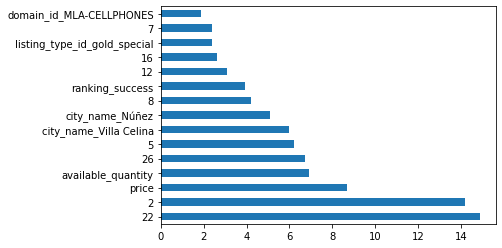

In [101]:
feat_importances = pd.Series(cbr.best_estimator_.get_feature_importance(), index=X_test.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [102]:
model_comparison

,Model,Train_score,Test_score
1,CatBoostRegressor,0.375287,0.240493


<a href="#top">Back to Index</a>
<a id="4"></a>
### 4) Conclusion de Parte II

En esta instancia se trato de realizar un modelo para poder predecir las unidades vendidas *sold_quantity* de una publicacion.
Si bien los valores obtenidos son bajos, hay que tomar en cuenta la informacion del data set.
Existen muchos datos referidos al vendedor, y los elementos de tag son muy genericos no necesariamente de la publicacion, posiblemente con datos especificos de las publicaciones utilizando otro recurso de la API de MELI se pueden obtener datos referentes al producto del campo ***atributes: {}*** mediante la ***id*** de cada publicacion.

Tambien mas que hacerlo generico, crearia un modelo para cada uno de las distintas categorias del modelo,
ya sea televisores, celulares, etc. y repetir el entrenamiento, muy posiblemente algunas variables sean comunes.

Queda pendiente, al momento de usar Vectorizamos con ***TfidfVectorizer***, identificar el nombre de las variables de la matriz exparsa con las palabras de ***tags*** para poder ver con el feature importance 



##### Edit: EXTRA
##### Como extra tratare de traer atributos extra de la publicacion referidos al producto en si, por ello aun conserve id en este punto.

In [103]:
## extra get data
import requests
from time import time, sleep
import re

# hago otra consulta
url = 'https://api.mercadolibre.com/items/MLA898264823'
result = requests.get(url)
consulta = result.json()

In [104]:
consulta['attributes']

[{'id': 'BRAND',
  'name': 'Marca',
  'value_id': '16457',
  'value_name': 'TCL',
  'value_struct': None,
  'values': [{'id': '16457', 'name': 'TCL', 'struct': None}],
  'attribute_group_id': 'MAIN',
  'attribute_group_name': 'Principales'},
 {'id': 'MODEL',
  'name': 'Modelo',
  'value_id': '7803013',
  'value_name': '50P8M',
  'value_struct': None,
  'values': [{'id': '7803013', 'name': '50P8M', 'struct': None}],
  'attribute_group_id': 'MAIN',
  'attribute_group_name': 'Principales'},
 {'id': 'ACCESSORIES_INCLUDED',
  'name': 'Accesorios incluidos',
  'value_id': None,
  'value_name': 'Control remoto,Baterías,Cable de alimentación',
  'value_struct': None,
  'values': [{'id': '2296420', 'name': 'Control remoto', 'struct': None},
   {'id': None, 'name': 'Baterías', 'struct': None},
   {'id': '7609642', 'name': 'Cable de alimentación', 'struct': None}],
  'attribute_group_id': 'OTHERS',
  'attribute_group_name': 'Otros'},
 {'id': 'ASPECT_RATIO',
  'name': 'Relación de aspecto',
  'val

In [105]:
auxic = pd.DataFrame(consulta['attributes']).T
auxic.columns = auxic.iloc[0]
auxic = auxic[auxic.index == 'value_name']#.reset_index(drop = True)
auxic.index = ['prueba']
auxic

id,BRAND,MODEL,ACCESSORIES_INCLUDED,ASPECT_RATIO,BRIGHTNESS,COLOR,CONTRAST_RATIO,DEPTH,DISPLAY_SIZE,DISPLAY_TYPE,...,WEIGHT,WIDTH,WITH_BLUETOOTH,WITH_ETHERNET,WITH_HDMI,WITH_HDR,WITH_INTEGRATED_VOICE_COMMAND,WITH_SCREEN_SHARE_FUNCTION,WITH_USB,WITH_WI_FI
prueba,TCL,50P8M,"Control remoto,Baterías,Cable de alimentación",16:9,270 cd/m²,Negro,5000:1,8.1 cm,"50 """,LED,...,9.8 kg,112.1 cm,Sí,Sí,Sí,Sí,Sí,Sí,Sí,Sí


In [106]:
# voy a definir una función para realizar las consultas, y tomar el resultado y entregarlo como un dataset
def call_data2(serie_id, serie_index):
    '''Funcion para llamar a la API de mercado libre con un resultado especifico para cada idem extrayendo los datos en un dataframe
    y guardandolas en un data frame'''
    t = len(serie_id)
    df_rta = pd.DataFrame() #instancio un dataframe vacio, si bien no es una buena practica para este caso es una alternativa
    for t in list(range( 0,len(serie_id),1 ) ):
        url_act = 'https://api.mercadolibre.com/items/' + str( serie_id[t] )
        #print(url_act) #solo para corroborar
        result = requests.get(url_act)
        if result.status_code == 200:
            try:
                auxic = pd.DataFrame( result.json()['attributes'] ).T
                auxic.columns = auxic.iloc[0]
                auxic = auxic[auxic.index == 'value_name']#.reset_index(drop = True)
                auxic.index = [serie_index[t]]
                df_rta = pd.concat([df_rta, auxic], axis = 0)
            except KeyError:
                continue
        else:
            print('hubo un error')
            return df_rta
        print(t, end="\r")
        sleep(10) #cada 15 segundos ##cambio a 10 seg
          
    return df_rta

In [107]:
call_data2(list(data_m.id[data_m.index[[3,3245]]]), list(data_m.index[[3,3245]]))

,BRAND,MODEL,ACCESSORIES_INCLUDED,ADDITIONAL_INFO_REQUIRED,ALPHANUMERIC_MODEL,ASPECT_RATIO,COLOR,DEPTH,DISPLAY_SIZE,DISPLAY_TYPE,...,VIDEO_MEMORY,VIDEO_PORTS,WEBCAM_RESOLUTION,WITH_ANTIREFLEX_SCREEN,WITH_HEADPHONES_OUTPUT,WITH_MEMORY_CARD_READER,WITH_MICROPHONE,WITH_NUMERIC_PAD,WITH_TOUCH_SCREEN,WITH_WEBCAM
3,Samsung,UN50TU7000,"Cable de alimentación,Mini soporte de montaje ...",Tiene número de serie,UN50TU7000GCZB,16:9,Negro,59.9 mm,"50 """,LED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4009,Lenovo,81UT00EAUS,NaN,NaN,S145-15API,NaN,NaN,251.5 mm,"15 """,LED,...,None,HDMI,0.3 Mpx,Sí,Sí,Sí,Sí,Sí,None,Sí


<p><strong> Para esta instancia tendria que realizar una consulta cada 15 segundos para no saturar la API.
    un total de 3422 consultas implicaria 51.330 segundos, poco mas de 14,25 hs (14hs y 15min). Por lo tanto solamente me concentrare en las consultas relacionadas con celulares, es decir, <i>domain_id == MLA/CELLPHONES</i>.</strong></p>

In [108]:
data_cell = data_m[data_m.domain_id == 'MLA-CELLPHONES'].copy()
data_cell

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up,id
1047,37999.00,0.000000,200,77,gold_pro,new,MLA-CELLPHONES,extended warranty eligible good quality p...,Capital Federal,Belgrano,platinum,5_green,0.955645,0.01,0.98,0,0,MLA913276815
1048,30999.00,0.000000,1694,2498,gold_pro,new,MLA-CELLPHONES,x campaign extended warranty eligible ...,Buenos Aires,Villa Celina,platinum,5_green,0.953779,0.06,0.93,0,0,MLA914656011
1049,57999.00,0.000000,27,40,gold_pro,new,MLA-CELLPHONES,extended warranty eligible good quality p...,Capital Federal,Belgrano,platinum,5_green,0.955645,0.01,0.98,0,0,MLA915042596
1050,44999.00,0.081634,213,668,gold_pro,new,MLA-CELLPHONES,loyalty discount eligible extended warran...,Capital Federal,Belgrano,platinum,5_green,0.955645,0.01,0.98,0,0,MLA918701162
1051,15499.00,0.000000,105,5455,gold_pro,new,MLA-CELLPHONES,brand verified extended warranty eligible...,Capital Federal,Núñez,platinum,5_green,0.949716,0.05,0.93,0,0,MLA885844347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,24500.00,0.000000,1,3,gold_special,new,MLA-CELLPHONES,extended warranty eligible good quality p...,Capital Federal,Belgrano,platinum,5_green,0.918064,0.03,0.94,0,0,MLA933233919
2066,19999.00,0.000000,200,1,gold_special,new,MLA-CELLPHONES,extended warranty eligible good quality p...,Capital Federal,Balvanera,platinum,5_green,0.941431,0.04,0.91,0,0,MLA931475073
2069,79999.00,0.000000,1,2,gold_pro,new,MLA-CELLPHONES,x campaign extended warranty eligible ...,Capital Federal,Núñez,platinum,5_green,0.949716,0.05,0.93,0,0,MLA914092673
2070,16659.05,0.090000,1,5,gold_pro,new,MLA-CELLPHONES,brand verified extended warranty eligible...,Buenos Aires,Hurlingham,platinum,5_green,0.920480,0.02,0.96,0,0,MLA902118732


In [111]:
data_cell_att =call_data2(list(data_cell.id[data_cell.index[range(0,780,1)]]), list(data_cell.index[range(0,780,1)]))

#data_cell_attributes=call_data2(list(data_cell.id[data_cell.index[range(0,100,1)]]), list(data_cell.index[range(0,100,1)]))
#sleep(10)
#data_cell_attributes2=call_data2(list(data_cell.id[data_cell.index[range(100,200,1)]]), list(data_cell.index[range(100,200,1)]))
#sleep(10)
#data_cell_attributes3=call_data2(list(data_cell.id[data_cell.index[range(200,300,1)]]), list(data_cell.index[range(200,300,1)]))
#sleep(10)
#data_cell_attributes4=call_data2(list(data_cell.id[data_cell.index[range(300,400,1)]]), list(data_cell.index[range(300,400,1)]))
#sleep(10)
#data_cell_attributes5=call_data2(list(data_cell.id[data_cell.index[range(400,500,1)]]), list(data_cell.index[range(400,500,1)]))
#sleep(10)
#data_cell_attributes6=call_data2(list(data_cell.id[data_cell.index[range(500,600,1)]]), list(data_cell.index[range(500,600,1)]))
#sleep(10)
#data_cell_attributes7=call_data2(list(data_cell.id[data_cell.index[range(600,700,1)]]), list(data_cell.index[range(600,700,1)]))
#sleep(10)
#data_cell_attributes8=call_data2(list(data_cell.id[data_cell.index[range(700,780,1)]]), list(data_cell.index[range(700,780,1)]))

In [112]:
#data_cell_att = pd.concat([data_cell_attributes,\
#           data_cell_attributes2,
#           data_cell_attributes3,
#           data_cell_attributes4,
#           data_cell_attributes5,
#           data_cell_attributes6,
#           data_cell_attributes7,
#           data_cell_attributes8], axis = 0)
data_cell_att

,BATTERY_CAPACITY,BATTERY_TYPE,BRAND,CARRIER,CHARGE_CONNECTOR_TYPE,COLOR,CPU_MODELS,DEPTH,DIGITAL_ZOOM,DISPLAY_MAX_BRIGHTNESS,...,SECONDARY_FOLDED_DISPLAY_PIXELS_PER_INCH,SECONDARY_FOLDED_DISPLAY_RESOLUTION,SECONDARY_FOLDED_DISPLAY_SIZE,WITH_FOLDABLE_DISPLAY,WITH_SECONDARY_FOLDED_DISPLAY,WITH_SECONDARY_TOUCHSCREEN_DISPLAY,MAX_BRIGHTNESS,SCREEN_TECHNOLOGY,WITH_SLOW_MOTION_CAMERA_FUNCTION,WITH_FOLDABLE_SCREEN
1047,5000 mAh,Polímero de litio,Samsung,Liberado,USB-C,Azul,8x2 GHz Cortex-A55,8.9 mm,8x,625 cd/m²,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048,5000 mAh,Polímero de litio,Samsung,Liberado,USB-C,Azul,"4x1.8 GHz Cortex-A53,4x2.35 GHz Cortex-A53",8.9 mm,10x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,4500 mAh,Polímero de litio,Samsung,Liberado,USB-C,Awesome blue,"2x2.3 GHz Kryo 465 Gold,6x1.8 GHz Kryo 465 Silver",8.4 mm,10x,800 cd/m²,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1050,5000 mAh,NaN,Samsung,Liberado,USB-C,Awesome black,"2x2 GHz Cortex-A75,6x1.8 GHz Cortex-A55",8.4 mm,10x,800 cd/m²,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1051,3000 mAh,Ion de litio,Samsung,Liberado,Micro USB,Negro,4x1.5 GHz Cortex-A53,8.6 mm,4x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,3500 mAh,Ion de litio,Samsung,Liberado,USB-C,NaN,NaN,7.9 mm,10x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029,2100 mAh,Ion de litio,Kodak,Liberado,NaN,NaN,NaN,10.2 mm,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2032,5000 mAh,Polímero de litio,Samsung,Liberado,USB-C,NaN,"4x1.8 GHz Cortex-A53,4x2.35 GHz Cortex-A53",8.9 mm,10x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,3000 mAh,Ion de litio,Samsung,Liberado,Micro USB,NaN,4x1.5 GHz Cortex-A53,8.6 mm,4x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# debido a la alerta de memory usage lo fracciono en dos partes
data_cell_att.iloc[:, list(range(0,100,1))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 1047 to 2034
Data columns (total 100 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   BATTERY_CAPACITY                                 762 non-null    object
 1   BATTERY_TYPE                                     572 non-null    object
 2   BRAND                                            780 non-null    object
 3   CARRIER                                          780 non-null    object
 4   CHARGE_CONNECTOR_TYPE                            580 non-null    object
 5   COLOR                                            124 non-null    object
 6   CPU_MODELS                                       507 non-null    object
 7   DEPTH                                            718 non-null    object
 8   DIGITAL_ZOOM                                     279 non-null    object
 9   DISPLAY_MAX_BRIGHTNESS                

In [117]:
# debido a la alerta de memory usage lo fracciono en dos partes
data_cell_att.iloc[:, list(range(100,145,1))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 1047 to 2034
Data columns (total 45 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   FRONT_CAMERAS_RESOLUTION                                48 non-null     object
 1   SECONDARY_DISPLAY_MAX_BRIGHTNESS                        7 non-null      object
 2   SECONDARY_DISPLAY_PIXELS_PER_INCH                       29 non-null     object
 3   DIMENSIONS                                              2 non-null      object
 4   WITH_LANTERN                                            2 non-null      object
 5   DETAILED_MODEL                                          26 non-null     object
 6   ORIGIN                                                  77 non-null     object
 7   OPTICAL_ZOOM                                            41 non-null     object
 8   ADDITIONAL_INFO_REQUIRED                      

Existe una gran cantidad de elementos no nulos en el dataframe *data_cell_att*, por lo tanto voy a filtrar aquellos que tengan una gran cantidad de valores nulos (al menos 100).

In [118]:
columns_att = list(data_cell_att.columns)
columns_att_less_nulls = []
for atributo in columns_att:
    if data_cell_att[atributo].isnull().sum() < 100:
        columns_att_less_nulls.extend( [atributo] )
        #print(atributo) #para comprobar
        
len(columns_att_less_nulls)

35

In [119]:
columns_att_less_nulls

['BATTERY_CAPACITY',
 'BRAND',
 'CARRIER',
 'DEPTH',
 'DISPLAY_PIXELS_PER_INCH',
 'DISPLAY_RESOLUTION',
 'DISPLAY_SIZE',
 'FRONT_CAMERAS_NUMBER',
 'HEIGHT',
 'INTERNAL_MEMORY',
 'IS_DUAL_SIM',
 'ITEM_CONDITION',
 'MAIN_FRONT_CAMERA_RESOLUTION',
 'MAIN_REAR_CAMERA_RESOLUTION',
 'MEMORY_CARD_TYPES',
 'MOBILE_NETWORK',
 'MODEL',
 'NUMBER_OF_SIM_CARD_SLOTS',
 'OPERATING_SYSTEM_NAME',
 'OPERATING_SYSTEM_ORIGINAL_VERSION',
 'PROCESSOR_CORES_NUMBER',
 'PROCESSOR_SPEED',
 'RAM',
 'REAR_CAMERAS_NUMBER',
 'SIM_SIZES',
 'WEIGHT',
 'WIDTH',
 'WITH_BLUETOOTH',
 'WITH_CAMERA',
 'WITH_GPS',
 'WITH_IMEI',
 'WITH_PHYSICAL_QWERTY_KEYBOARD',
 'WITH_TOUCHSCREEN_DISPLAY',
 'WITH_USB_CONNECTOR',
 'WITH_WIFI']

In [120]:
data_cell_att[columns_att_less_nulls].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 1047 to 2034
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   BATTERY_CAPACITY                   762 non-null    object
 1   BRAND                              780 non-null    object
 2   CARRIER                            780 non-null    object
 3   DEPTH                              718 non-null    object
 4   DISPLAY_PIXELS_PER_INCH            689 non-null    object
 5   DISPLAY_RESOLUTION                 722 non-null    object
 6   DISPLAY_SIZE                       747 non-null    object
 7   FRONT_CAMERAS_NUMBER               681 non-null    object
 8   HEIGHT                             717 non-null    object
 9   INTERNAL_MEMORY                    780 non-null    object
 10  IS_DUAL_SIM                        780 non-null    object
 11  ITEM_CONDITION                     780 non-null    object
 12  MAIN

In [236]:
data_cell_att_minus = data_cell_att[columns_att_less_nulls].copy()

In [237]:
data_cell_att_minus.shape

(780, 35)

Existen campos vacios o no especificados, en esta instancia en lugar de incorporar una opcion mas, como NE no especifica, directamente colocaré NO ya que aquellos campos donde hay faltantes de campos pertenecen a productos de gama baja

In [238]:
# completo los valores de los campos en lugar 
columnas_sino = ['IS_DUAL_SIM','WITH_BLUETOOTH','WITH_CAMERA','WITH_GPS','WITH_IMEI','WITH_PHYSICAL_QWERTY_KEYBOARD',\
                 'WITH_TOUCHSCREEN_DISPLAY','WITH_USB_CONNECTOR','WITH_WIFI',\
# considero estas opciones posiblemente aca sea mejor una etiqueta como NE. Pero el nombre de la ettiqueta no hara efecto.
                'OPERATING_SYSTEM_NAME','MAIN_FRONT_CAMERA_RESOLUTION','MAIN_REAR_CAMERA_RESOLUTION']

In [239]:
# completo los valores vacios con No
data_cell_att_minus[columnas_sino] = data_cell_att_minus[columnas_sino].fillna('No')
data_cell_att_minus[columnas_sino]

,IS_DUAL_SIM,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI,OPERATING_SYSTEM_NAME,MAIN_FRONT_CAMERA_RESOLUTION,MAIN_REAR_CAMERA_RESOLUTION
1047,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,13 Mpx,48 Mpx
1048,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,8 Mpx,48 Mpx
1049,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,32 Mpx,64 Mpx
1050,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,20 Mpx,64 Mpx
1051,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,5 Mpx,8 Mpx
...,...,...,...,...,...,...,...,...,...,...,...,...
2024,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,10 Mpx,16 Mpx
2029,Sí,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,8 Mpx,8 Mpx
2032,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,8 Mpx,48 Mpx
2033,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,5 Mpx,8 Mpx


In [240]:
data_cell_att_minus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 1047 to 2034
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   BATTERY_CAPACITY                   762 non-null    object
 1   BRAND                              780 non-null    object
 2   CARRIER                            780 non-null    object
 3   DEPTH                              718 non-null    object
 4   DISPLAY_PIXELS_PER_INCH            689 non-null    object
 5   DISPLAY_RESOLUTION                 722 non-null    object
 6   DISPLAY_SIZE                       747 non-null    object
 7   FRONT_CAMERAS_NUMBER               681 non-null    object
 8   HEIGHT                             717 non-null    object
 9   INTERNAL_MEMORY                    780 non-null    object
 10  IS_DUAL_SIM                        780 non-null    object
 11  ITEM_CONDITION                     780 non-null    object
 12  MAIN

In [241]:
# defino funcion para limpieza
def limpieza(df_l, atributo_l, palabra_l):
    posiciones = list(df_l[df_l[atributo_l].str.contains(palabra_l, na=False, regex=True)][atributo_l].index)
    rta = df_l.loc[posiciones,[atributo_l]][atributo_l].str.replace(palabra_l,'')
    rta.values
    return rta.values , posiciones

In [242]:
# vamos por las dimensiones
a, b = limpieza(data_cell_att_minus,'DEPTH', 'mm')
data_cell_att_minus.loc[b, 'DEPTH'] = a

a, b = limpieza(data_cell_att_minus,'DEPTH', 'cm')
data_cell_att_minus.loc[b, 'DEPTH'] = a
data_cell_att_minus['DEPTH']=data_cell_att_minus['DEPTH'].astype('float32')
data_cell_att_minus.loc[b, 'DEPTH'] = data_cell_att_minus.loc[b, 'DEPTH']*10

a, b = limpieza(data_cell_att_minus,'HEIGHT', 'mm')
data_cell_att_minus.loc[b, 'HEIGHT'] = a

a, b = limpieza(data_cell_att_minus,'HEIGHT', 'cm')
data_cell_att_minus.loc[b, 'HEIGHT'] = a
data_cell_att_minus['HEIGHT']=data_cell_att_minus['HEIGHT'].astype('float32')
data_cell_att_minus.loc[b, 'HEIGHT'] = data_cell_att_minus.loc[b, 'HEIGHT']*10

a, b = limpieza(data_cell_att_minus,'WIDTH', 'mm')
data_cell_att_minus.loc[b, 'WIDTH'] = a

a, b = limpieza(data_cell_att_minus,'WIDTH', 'cm')
data_cell_att_minus.loc[b, 'WIDTH'] = a
data_cell_att_minus['WIDTH']=data_cell_att_minus['WIDTH'].astype('float32')
data_cell_att_minus.loc[b, 'WIDTH'] = data_cell_att_minus.loc[b, 'WIDTH']*10

In [243]:
# vamos por el peso
a, b = limpieza(data_cell_att_minus,'WEIGHT', 'g')
data_cell_att_minus.loc[b, 'WEIGHT'] = a

a, b = limpieza(data_cell_att_minus,'WEIGHT', 'k')
data_cell_att_minus.loc[b, 'WEIGHT'] = a
data_cell_att_minus['WEIGHT']=data_cell_att_minus['WEIGHT'].astype('float32')
data_cell_att_minus.loc[b, 'WEIGHT'] = data_cell_att_minus.loc[b, 'WEIGHT']*1000

In [244]:
# vamos por el tamaño de la pantalla
a, b = limpieza(data_cell_att_minus,'DISPLAY_SIZE', '"')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = a

a, b = limpieza(data_cell_att_minus,'DISPLAY_SIZE', 'pulgadas')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = a

a, b = limpieza(data_cell_att_minus,'DISPLAY_SIZE', 'mm')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = a
data_cell_att_minus['DISPLAY_SIZE']=data_cell_att_minus['DISPLAY_SIZE'].astype('float32')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = data_cell_att_minus.loc[b, 'DISPLAY_SIZE']/25.4

A diferencia de los casos no especificados, en este caso imputaré con la media.

In [245]:
# voy a imputar con la media
data_cell_att_minus['DEPTH'].fillna((data_cell_att_minus['DEPTH'].mean()), inplace=True)
data_cell_att_minus['HEIGHT'].fillna((data_cell_att_minus['HEIGHT'].mean()), inplace=True)
data_cell_att_minus['WIDTH'].fillna((data_cell_att_minus['WIDTH'].mean()), inplace=True)
data_cell_att_minus['WEIGHT'].fillna((data_cell_att_minus['WEIGHT'].mean()), inplace=True)
data_cell_att_minus['DISPLAY_SIZE'].fillna((data_cell_att_minus['DISPLAY_SIZE'].mean()), inplace=True)

In [246]:
## algunas transformaciones extra:
data_cell_att_minus['PROCESSOR_CORES_NUMBER']=data_cell_att_minus['PROCESSOR_CORES_NUMBER'].notnull().astype('int')
data_cell_att_minus['REAR_CAMERAS_NUMBER']=data_cell_att_minus['REAR_CAMERAS_NUMBER'].notnull().astype('int')
data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS']=data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'].notnull().astype('int')

In [247]:
# veamos los tipos de redes
data_cell_att_minus['MOBILE_NETWORK'].value_counts()

4G/LTE            606
3G                 53
2G                 26
5G                 25
2G y 3G             1
2G, 3G, 4G LTE      1
Name: MOBILE_NETWORK, dtype: int64

Como las redes son que poseen acceso a las últimas redes, 4G o 5G por default poseen las anteriores.

In [248]:
# reemplazo los valores anomalos
data_cell_att_minus['MOBILE_NETWORK'] = data_cell_att_minus['MOBILE_NETWORK'].replace(['2G y 3G','2G, 3G, 4G LTE'],\
                                                                                      ['3G','4G/LTE'])

In [249]:
# checkeo los tipos de redes
data_cell_att_minus['MOBILE_NETWORK'].value_counts()

4G/LTE    607
3G         54
2G         26
5G         25
Name: MOBILE_NETWORK, dtype: int64

In [250]:
# imputo con el valor mas comun
data_cell_att_minus['REAR_CAMERAS_NUMBER'] = data_cell_att_minus['REAR_CAMERAS_NUMBER'].\
    fillna(data_cell_att_minus['REAR_CAMERAS_NUMBER'].value_counts().index[0])
data_cell_att_minus['PROCESSOR_CORES_NUMBER'] = data_cell_att_minus['PROCESSOR_CORES_NUMBER'].\
    fillna(data_cell_att_minus['PROCESSOR_CORES_NUMBER'].value_counts().index[0])
data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'] = data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'].\
    fillna(data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'].value_counts().index[0])
data_cell_att_minus['BATTERY_CAPACITY'] = data_cell_att_minus['BATTERY_CAPACITY'].\
    fillna(data_cell_att_minus['BATTERY_CAPACITY'].value_counts().index[0])
data_cell_att_minus['MOBILE_NETWORK'] = data_cell_att_minus['MOBILE_NETWORK'].\
    fillna(data_cell_att_minus['MOBILE_NETWORK'].value_counts().index[0])

In [251]:
data_cell_att_minus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 1047 to 2034
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BATTERY_CAPACITY                   780 non-null    object 
 1   BRAND                              780 non-null    object 
 2   CARRIER                            780 non-null    object 
 3   DEPTH                              780 non-null    float32
 4   DISPLAY_PIXELS_PER_INCH            689 non-null    object 
 5   DISPLAY_RESOLUTION                 722 non-null    object 
 6   DISPLAY_SIZE                       780 non-null    float32
 7   FRONT_CAMERAS_NUMBER               681 non-null    object 
 8   HEIGHT                             780 non-null    float32
 9   INTERNAL_MEMORY                    780 non-null    object 
 10  IS_DUAL_SIM                        780 non-null    object 
 11  ITEM_CONDITION                     780 non-null    obj

In [252]:
data_cell_att_minus

,BATTERY_CAPACITY,BRAND,CARRIER,DEPTH,DISPLAY_PIXELS_PER_INCH,DISPLAY_RESOLUTION,DISPLAY_SIZE,FRONT_CAMERAS_NUMBER,HEIGHT,INTERNAL_MEMORY,...,WEIGHT,WIDTH,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
1047,5000 mAh,Samsung,Liberado,8.9,270 ppi,720 px x 1600 px,6.500000,1,163.699997,128 GB,...,192.0,75.300003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1048,5000 mAh,Samsung,Liberado,8.9,264 ppi,720 px x 1600 px,6.500000,1,164.000000,64 GB,...,205.0,75.800003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1049,4500 mAh,Samsung,Liberado,8.4,405 ppi,1080 px x 2400 px,6.500000,1,159.899994,128 GB,...,189.0,75.099998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1050,5000 mAh,Samsung,Liberado,8.4,411 ppi,1080 px x 2400 px,6.400000,1,158.899994,128 GB,...,184.0,73.599998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1051,3000 mAh,Samsung,Liberado,8.6,311 ppi,720 px x 1480 px,5.300000,1,141.699997,16 GB,...,150.0,67.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024,3500 mAh,Samsung,Liberado,7.9,401 ppi,1080 px x 2280 px,6.300000,1,151.000000,256 GB,...,168.0,71.800003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2029,2100 mAh,Kodak,Liberado,10.2,193 ppi,442 px x 960 px,5.450000,1,139.899994,16 GB,...,142.0,66.199997,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2032,5000 mAh,Samsung,Liberado,8.9,264 ppi,720 px x 1600 px,6.500000,1,164.000000,128 GB,...,205.0,75.800003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2033,3000 mAh,Samsung,Liberado,8.6,311 ppi,720 px x 1480 px,5.300000,1,141.699997,16 GB,...,150.0,67.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


##### Ahora probemos nuevamente un modelo; pero añadiendo parte del otro data set

In [253]:
data_cell_att_minus.columns

Index(['BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'DEPTH',
       'DISPLAY_PIXELS_PER_INCH', 'DISPLAY_RESOLUTION', 'DISPLAY_SIZE',
       'FRONT_CAMERAS_NUMBER', 'HEIGHT', 'INTERNAL_MEMORY', 'IS_DUAL_SIM',
       'ITEM_CONDITION', 'MAIN_FRONT_CAMERA_RESOLUTION',
       'MAIN_REAR_CAMERA_RESOLUTION', 'MEMORY_CARD_TYPES', 'MOBILE_NETWORK',
       'MODEL', 'NUMBER_OF_SIM_CARD_SLOTS', 'OPERATING_SYSTEM_NAME',
       'OPERATING_SYSTEM_ORIGINAL_VERSION', 'PROCESSOR_CORES_NUMBER',
       'PROCESSOR_SPEED', 'RAM', 'REAR_CAMERAS_NUMBER', 'SIM_SIZES', 'WEIGHT',
       'WIDTH', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS', 'WITH_IMEI',
       'WITH_PHYSICAL_QWERTY_KEYBOARD', 'WITH_TOUCHSCREEN_DISPLAY',
       'WITH_USB_CONNECTOR', 'WITH_WIFI'],
      dtype='object')

In [254]:
atributos_seleccionados = ['BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'DEPTH',
       'DISPLAY_SIZE', 'HEIGHT', 'INTERNAL_MEMORY', 'IS_DUAL_SIM',
       'ITEM_CONDITION', 'MAIN_FRONT_CAMERA_RESOLUTION',
       'MAIN_REAR_CAMERA_RESOLUTION','MOBILE_NETWORK',
        'NUMBER_OF_SIM_CARD_SLOTS', 'OPERATING_SYSTEM_NAME',
       'PROCESSOR_CORES_NUMBER', 'RAM', 'REAR_CAMERAS_NUMBER',
       'WEIGHT', 'WIDTH', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS',
       'WITH_IMEI', 'WITH_PHYSICAL_QWERTY_KEYBOARD',
       'WITH_TOUCHSCREEN_DISPLAY', 'WITH_USB_CONNECTOR', 'WITH_WIFI']
data_cell_att_minus[atributos_seleccionados].head()

,BATTERY_CAPACITY,BRAND,CARRIER,DEPTH,DISPLAY_SIZE,HEIGHT,INTERNAL_MEMORY,IS_DUAL_SIM,ITEM_CONDITION,MAIN_FRONT_CAMERA_RESOLUTION,...,WEIGHT,WIDTH,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
1047,5000 mAh,Samsung,Liberado,8.9,6.5,163.699997,128 GB,No,Nuevo,13 Mpx,...,192.0,75.300003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1048,5000 mAh,Samsung,Liberado,8.9,6.5,164.000000,64 GB,No,Nuevo,8 Mpx,...,205.0,75.800003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1049,4500 mAh,Samsung,Liberado,8.4,6.5,159.899994,128 GB,No,Nuevo,32 Mpx,...,189.0,75.099998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1050,5000 mAh,Samsung,Liberado,8.4,6.4,158.899994,128 GB,No,Nuevo,20 Mpx,...,184.0,73.599998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1051,3000 mAh,Samsung,Liberado,8.6,5.3,141.699997,16 GB,No,Nuevo,5 Mpx,...,150.0,67.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


In [255]:
data_cell_ext = pd.concat([data_cell, data_cell_att_minus[atributos_seleccionados]], axis = 1)
data_cell_ext.head()

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,...,WEIGHT,WIDTH,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
1047,37999.0,0.000000,200,77,gold_pro,new,MLA-CELLPHONES,extended warranty eligible good quality p...,Capital Federal,Belgrano,...,192.0,75.300003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1048,30999.0,0.000000,1694,2498,gold_pro,new,MLA-CELLPHONES,x campaign extended warranty eligible ...,Buenos Aires,Villa Celina,...,205.0,75.800003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1049,57999.0,0.000000,27,40,gold_pro,new,MLA-CELLPHONES,extended warranty eligible good quality p...,Capital Federal,Belgrano,...,189.0,75.099998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1050,44999.0,0.081634,213,668,gold_pro,new,MLA-CELLPHONES,loyalty discount eligible extended warran...,Capital Federal,Belgrano,...,184.0,73.599998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1051,15499.0,0.000000,105,5455,gold_pro,new,MLA-CELLPHONES,brand verified extended warranty eligible...,Capital Federal,Núñez,...,150.0,67.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


In [256]:
data_cell_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 1047 to 2071
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          801 non-null    float64
 1   discount                       801 non-null    float64
 2   available_quantity             801 non-null    int64  
 3   sold_quantity                  801 non-null    int64  
 4   listing_type_id                801 non-null    object 
 5   condition                      801 non-null    object 
 6   domain_id                      801 non-null    object 
 7   tags                           801 non-null    object 
 8   state_name                     801 non-null    object 
 9   city_name                      801 non-null    object 
 10  power_seller_status            801 non-null    object 
 11  level_id                       801 non-null    object 
 12  ranking_success                801 non-null   

In [257]:
data_cell_ext.dropna(inplace = True)

In [258]:
data_cell_ext = data_cell_ext.drop(['id', 'domain_id'],axis =1)

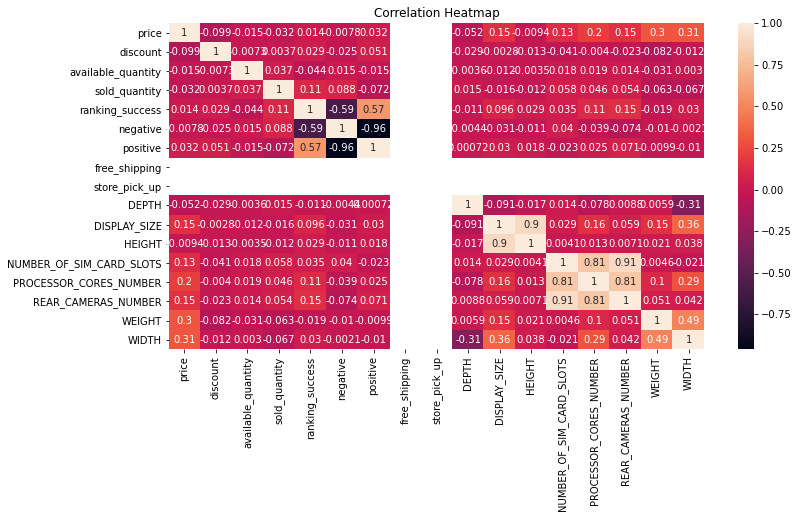

In [259]:
# graficamos un heatmap para exploras la relacion entre variables
plt.figure(figsize=(12,6))
# para no incorporar solamente aquellas variables numericas, ya que de lo contrario me tomaria los buleanos 
num_cols = [x for x in data_cell_ext.select_dtypes(include=['number']).columns]
sns.heatmap(data_cell_ext[num_cols].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [260]:
data_cell_ext['free_shipping']=data_cell_ext['free_shipping'].astype('category')
data_cell_ext['store_pick_up']=data_cell_ext['store_pick_up'].astype('category')
data_cell_ext['free_shipping']=data_cell_ext['free_shipping'].apply(lambda x: 1 if x == 'True' else 0)
data_cell_ext['store_pick_up']=data_cell_ext['store_pick_up'].apply(lambda x: 1 if x == 'True' else 0)

In [316]:
X=data_cell_ext[[x for x in data_cell_ext.columns if x !='sold_quantity']]
y=data_cell_ext['sold_quantity']

# split usando una relación de 80% de datos para train, y 20% datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [317]:
# armo las listas de variables categorias y numericas
num_features = [x for x in X.select_dtypes(include=['number']).columns]
cat_features = [x for x in X.columns if x not in num_features]
print('Variables categoricas: %s' %cat_features)
print('--------------------------------------------------')
print('Variables numericas: %s' %num_features)

Variables categoricas: ['listing_type_id', 'condition', 'tags', 'state_name', 'city_name', 'power_seller_status', 'level_id', 'free_shipping', 'store_pick_up', 'BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'INTERNAL_MEMORY', 'IS_DUAL_SIM', 'ITEM_CONDITION', 'MAIN_FRONT_CAMERA_RESOLUTION', 'MAIN_REAR_CAMERA_RESOLUTION', 'MOBILE_NETWORK', 'OPERATING_SYSTEM_NAME', 'RAM', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS', 'WITH_IMEI', 'WITH_PHYSICAL_QWERTY_KEYBOARD', 'WITH_TOUCHSCREEN_DISPLAY', 'WITH_USB_CONNECTOR', 'WITH_WIFI']
--------------------------------------------------
Variables numericas: ['price', 'discount', 'available_quantity', 'ranking_success', 'negative', 'positive', 'DEPTH', 'DISPLAY_SIZE', 'HEIGHT', 'NUMBER_OF_SIM_CARD_SLOTS', 'PROCESSOR_CORES_NUMBER', 'REAR_CAMERAS_NUMBER', 'WEIGHT', 'WIDTH']


In [318]:
# vamos a tener un tratamiento especial para tag
cat_features.remove('tags')
print('Variables categoricas: %s' %cat_features)

Variables categoricas: ['listing_type_id', 'condition', 'state_name', 'city_name', 'power_seller_status', 'level_id', 'free_shipping', 'store_pick_up', 'BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'INTERNAL_MEMORY', 'IS_DUAL_SIM', 'ITEM_CONDITION', 'MAIN_FRONT_CAMERA_RESOLUTION', 'MAIN_REAR_CAMERA_RESOLUTION', 'MOBILE_NETWORK', 'OPERATING_SYSTEM_NAME', 'RAM', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS', 'WITH_IMEI', 'WITH_PHYSICAL_QWERTY_KEYBOARD', 'WITH_TOUCHSCREEN_DISPLAY', 'WITH_USB_CONNECTOR', 'WITH_WIFI']


In [319]:
# stop_words=stop_words_m  no voy a sacar el ahora 12
vectorizer=TfidfVectorizer(lowercase=True,strip_accents='unicode',max_df=0.7)
vectorizer.fit(X_train['tags'])

TfidfVectorizer(max_df=0.7, strip_accents='unicode')

In [320]:
X_train_tags = pd.DataFrame(vectorizer.transform(X_train['tags']).todense(), columns = vectorizer.get_feature_names())
X_test_tags = pd.DataFrame(vectorizer.transform(X_test['tags']).todense(), columns = vectorizer.get_feature_names())

# tengo que dropear 'tags' y resetear los indices
X_train.drop(['tags'],axis =1, inplace = True)
X_test.drop(['tags'],axis =1, inplace = True)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [321]:
X_train_tags.head()

,and,best,bids,boost,brand,campaign,candidate,cart,catalog,discount,dragged,loyalty,moderation,penalty,poor,product,seller,verified,visits
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.437363,0.356578,0.462116,0.354633,0.0,0.354633,0.0,0.0,0.0,0.46528,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.780795,0.000000,0.000000,0.000000,0.441792,0.0,0.441792,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.447352,0.000000,0.338710,0.276147,0.357880,0.274641,0.0,0.274641,0.0,0.0,0.0,0.36033,0.0,0.447352,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.437363,0.356578,0.462116,0.354633,0.0,0.354633,0.0,0.0,0.0,0.46528,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0


In [322]:
# discount tambien lo uso en el dataset original asi que voy a renombrarlo
X_train_tags.rename(columns={'discount': 'discount_tags'}, inplace=True)
X_test_tags.rename(columns={'discount': 'discount_tags'}, inplace=True)

In [323]:
# tambien lo aplico  a y
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [324]:
X_test[cat_features]

,listing_type_id,condition,state_name,city_name,power_seller_status,level_id,free_shipping,store_pick_up,BATTERY_CAPACITY,BRAND,...,OPERATING_SYSTEM_NAME,RAM,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
0,gold_special,new,Capital Federal,Ciudad Autonoma de Buenos aires,platinum,5_green,0,0,4000 mAh,Alcatel,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1,gold_special,new,Capital Federal,Flores,platinum,5_green,0,0,1400 mAh,Panacom,...,No,512 MB,No,Sí,No,Sí,No,Sí,No,No
2,gold_pro,new,Capital Federal,Núñez,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
3,gold_pro,new,Capital Federal,Parque Patricios,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
4,gold_special,new,Capital Federal,Balvanera,platinum,5_green,0,0,5000 mAh,Motorola,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,gold_pro,new,Buenos Aires,Béccar,platinum,5_green,0,0,5000 mAh,Motorola,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
152,gold_special,new,Capital Federal,Palermo Soho,platinum,5_green,0,0,3110 mAh,Apple,...,iOS,4 GB,Sí,Sí,Sí,Sí,No,Sí,No,Sí
153,gold_pro,new,Buenos Aires,Villa Celina,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
154,gold_special,new,Córdoba,Villa María,platinum,5_green,0,0,5020 mAh,Xiaomi,...,Android,3 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


In [325]:
X_train[cat_features]

,listing_type_id,condition,state_name,city_name,power_seller_status,level_id,free_shipping,store_pick_up,BATTERY_CAPACITY,BRAND,...,OPERATING_SYSTEM_NAME,RAM,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
0,gold_special,new,Capital Federal,Once,platinum,5_green,0,0,2000 mAh,Quantum,...,Android,1 GB,Sí,Sí,No,Sí,No,Sí,Sí,Sí
1,gold_pro,new,Capital Federal,Barracas,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2,gold_special,new,Capital Federal,Parque Chacabuco,platinum,5_green,0,0,2700 mAh,Kodak,...,Android,1 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
3,gold_special,new,Capital Federal,Villa Ortúzar,platinum,5_green,0,0,2000 mAh,Quantum,...,Android,1 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
4,gold_special,new,Capital Federal,Villa Crespo,platinum,5_green,0,0,3000 mAh,Motorola,...,Android,2 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,gold_special,new,Capital Federal,Belgrano,platinum,5_green,0,0,2000 mAh,Quantum,...,Android,1 GB,Sí,Sí,No,Sí,No,Sí,Sí,Sí
620,gold_pro,new,Capital Federal,San Nicolás,platinum,5_green,0,0,1000 mAh,Energizer,...,No,32 MB,Sí,Sí,No,Sí,No,No,Sí,No
621,gold_special,new,Capital Federal,San Nicolás,platinum,5_green,0,0,800 mAh,Philco,...,Android,256 MB,Sí,Sí,No,Sí,No,No,Sí,Sí
622,gold_special,new,Buenos Aires,Junín,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,2 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


In [326]:
# con OneHotEncoder creamos variables dummies para place_name
onehot_encoder2 = OneHotEncoder(sparse=False,handle_unknown='ignore')

#X train enconded
X_ohe_train = onehot_encoder2.fit_transform(X_train[cat_features])
X_ohe_train = pd.DataFrame(X_ohe_train, columns = onehot_encoder2.get_feature_names(cat_features))

#X test enconded
X_ohe_test = onehot_encoder2.transform(X_test[cat_features])
X_ohe_test = pd.DataFrame(X_ohe_test, columns = onehot_encoder2.get_feature_names(cat_features))

In [327]:
# normalization of X_train
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train[num_features])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)

# normalization of X_test
X_test_scaled = min_max_scaler.transform(X_test[num_features])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)

In [328]:
print('Sizes de los distintos datasets de entrenamiento y testeo')
print('Train Tags Vectorizado: ',X_train_tags.shape)
print('Train Tags Vectorizado: ', X_test_tags.shape)
print('--------------------------------------------------')
print('Train OHE: ' ,X_ohe_train.shape)
print('Test OHE: ', X_ohe_test.shape)
print('--------------------------------------------------')
print('Train Scaled: ',X_train_scaled.shape)
print('Test Scaled: ', X_test_scaled.shape)

Sizes de los distintos datasets de entrenamiento y testeo
Train Tags Vectorizado:  (624, 19)
Train Tags Vectorizado:  (156, 19)
--------------------------------------------------
Train OHE:  (624, 273)
Test OHE:  (156, 273)
--------------------------------------------------
Train Scaled:  (624, 14)
Test Scaled:  (156, 14)


In [329]:
# concatenamos los datasets obtenidos hasta el momento
X_train = pd.concat([X_train_scaled, X_ohe_train , X_train_tags], axis = 1)
X_test = pd.concat([X_test_scaled, X_ohe_test, X_test_tags], axis = 1)

In [330]:
# luego de la unificacion
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(624, 306)

(156, 306)

(624,)

(156,)

In [331]:
# Instanciamos Cross Validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Instanciamos el modelo que vamos a entrenar
model_cbr = CatBoostRegressor()
model_comparison.loc[2,'Model'] = 'CatBoostRegressor_just_cells'

# Creamos la grilla de parametros
params = {  
      
    "depth": [5,6,7,8,9],            
    "learning_rate": [0.001, 0.01, 0.1],
    "l2_leaf_reg":[1.0,0.1]
}

# Creamos la grilla con GridSearch
cbr = GridSearchCV(model_cbr, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

# Entrenamos el modelo
cbr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 12.6min finished


0:	learn: 279.4822270	total: 24.9ms	remaining: 24.9s
1:	learn: 266.7561778	total: 43.9ms	remaining: 21.9s
2:	learn: 255.9652661	total: 62.8ms	remaining: 20.9s
3:	learn: 248.1600235	total: 113ms	remaining: 28.2s
4:	learn: 237.0458020	total: 133ms	remaining: 26.4s
5:	learn: 226.8305128	total: 150ms	remaining: 24.8s
6:	learn: 216.7476191	total: 165ms	remaining: 23.4s
7:	learn: 208.0457829	total: 179ms	remaining: 22.2s
8:	learn: 199.6585563	total: 187ms	remaining: 20.6s
9:	learn: 192.0460070	total: 201ms	remaining: 19.9s
10:	learn: 184.4974305	total: 217ms	remaining: 19.5s
11:	learn: 177.2212450	total: 232ms	remaining: 19.1s
12:	learn: 170.8102187	total: 249ms	remaining: 18.9s
13:	learn: 165.0933946	total: 255ms	remaining: 17.9s
14:	learn: 159.4081612	total: 268ms	remaining: 17.6s
15:	learn: 153.9675572	total: 285ms	remaining: 17.5s
16:	learn: 147.8666420	total: 299ms	remaining: 17.3s
17:	learn: 142.7324290	total: 313ms	remaining: 17.1s
18:	learn: 138.3778847	total: 326ms	remaining: 16.9s


168:	learn: 21.8395949	total: 2.75s	remaining: 13.5s
169:	learn: 21.8137400	total: 2.77s	remaining: 13.5s
170:	learn: 21.6687297	total: 2.79s	remaining: 13.5s
171:	learn: 21.5626437	total: 2.8s	remaining: 13.5s
172:	learn: 21.4626501	total: 2.82s	remaining: 13.5s
173:	learn: 21.1922016	total: 2.85s	remaining: 13.5s
174:	learn: 20.9771034	total: 2.86s	remaining: 13.5s
175:	learn: 20.7967693	total: 2.88s	remaining: 13.5s
176:	learn: 20.6511896	total: 2.89s	remaining: 13.4s
177:	learn: 20.6261110	total: 2.91s	remaining: 13.4s
178:	learn: 20.5186087	total: 2.92s	remaining: 13.4s
179:	learn: 20.2770616	total: 2.94s	remaining: 13.4s
180:	learn: 20.1782460	total: 2.95s	remaining: 13.4s
181:	learn: 20.0853442	total: 2.97s	remaining: 13.3s
182:	learn: 19.8837600	total: 2.99s	remaining: 13.3s
183:	learn: 19.7596335	total: 3.01s	remaining: 13.3s
184:	learn: 19.5849802	total: 3.02s	remaining: 13.3s
185:	learn: 19.3527994	total: 3.04s	remaining: 13.3s
186:	learn: 19.2815989	total: 3.05s	remaining: 

335:	learn: 9.7878760	total: 5.44s	remaining: 10.8s
336:	learn: 9.7592061	total: 5.46s	remaining: 10.7s
337:	learn: 9.7386649	total: 5.48s	remaining: 10.7s
338:	learn: 9.6996479	total: 5.49s	remaining: 10.7s
339:	learn: 9.6781245	total: 5.51s	remaining: 10.7s
340:	learn: 9.6561664	total: 5.52s	remaining: 10.7s
341:	learn: 9.6220202	total: 5.54s	remaining: 10.7s
342:	learn: 9.6156777	total: 5.55s	remaining: 10.6s
343:	learn: 9.6087367	total: 5.57s	remaining: 10.6s
344:	learn: 9.5748691	total: 5.58s	remaining: 10.6s
345:	learn: 9.5429108	total: 5.6s	remaining: 10.6s
346:	learn: 9.5232909	total: 5.62s	remaining: 10.6s
347:	learn: 9.4998449	total: 5.63s	remaining: 10.5s
348:	learn: 9.4927148	total: 5.64s	remaining: 10.5s
349:	learn: 9.4640067	total: 5.66s	remaining: 10.5s
350:	learn: 9.4493527	total: 5.68s	remaining: 10.5s
351:	learn: 9.4459100	total: 5.7s	remaining: 10.5s
352:	learn: 9.3923857	total: 5.71s	remaining: 10.5s
353:	learn: 9.3845980	total: 5.73s	remaining: 10.5s
354:	learn: 9.

503:	learn: 7.3401404	total: 8.18s	remaining: 8.05s
504:	learn: 7.3344813	total: 8.21s	remaining: 8.04s
505:	learn: 7.3136745	total: 8.22s	remaining: 8.03s
506:	learn: 7.3131956	total: 8.24s	remaining: 8.01s
507:	learn: 7.3075655	total: 8.25s	remaining: 7.99s
508:	learn: 7.3028809	total: 8.27s	remaining: 7.97s
509:	learn: 7.2973886	total: 8.28s	remaining: 7.96s
510:	learn: 7.2904458	total: 8.3s	remaining: 7.94s
511:	learn: 7.2858515	total: 8.31s	remaining: 7.92s
512:	learn: 7.2825596	total: 8.33s	remaining: 7.91s
513:	learn: 7.2718715	total: 8.34s	remaining: 7.89s
514:	learn: 7.2714600	total: 8.36s	remaining: 7.87s
515:	learn: 7.2652989	total: 8.38s	remaining: 7.86s
516:	learn: 7.2649087	total: 8.39s	remaining: 7.84s
517:	learn: 7.2610614	total: 8.41s	remaining: 7.82s
518:	learn: 7.2606645	total: 8.43s	remaining: 7.82s
519:	learn: 7.2588059	total: 8.45s	remaining: 7.8s
520:	learn: 7.2584012	total: 8.46s	remaining: 7.78s
521:	learn: 7.2508356	total: 8.48s	remaining: 7.76s
522:	learn: 7.

669:	learn: 6.7787865	total: 10.9s	remaining: 5.37s
670:	learn: 6.7786537	total: 10.9s	remaining: 5.36s
671:	learn: 6.7771114	total: 10.9s	remaining: 5.34s
672:	learn: 6.7767426	total: 11s	remaining: 5.32s
673:	learn: 6.7732600	total: 11s	remaining: 5.31s
674:	learn: 6.7719180	total: 11s	remaining: 5.3s
675:	learn: 6.7691361	total: 11s	remaining: 5.28s
676:	learn: 6.7685263	total: 11s	remaining: 5.26s
677:	learn: 6.7677072	total: 11s	remaining: 5.25s
678:	learn: 6.7658911	total: 11.1s	remaining: 5.23s
679:	learn: 6.7652110	total: 11.1s	remaining: 5.21s
680:	learn: 6.7642818	total: 11.1s	remaining: 5.19s
681:	learn: 6.7636730	total: 11.1s	remaining: 5.18s
682:	learn: 6.7610588	total: 11.1s	remaining: 5.16s
683:	learn: 6.7603363	total: 11.1s	remaining: 5.14s
684:	learn: 6.7596453	total: 11.1s	remaining: 5.13s
685:	learn: 6.7588129	total: 11.2s	remaining: 5.11s
686:	learn: 6.7564916	total: 11.2s	remaining: 5.09s
687:	learn: 6.7549320	total: 11.2s	remaining: 5.08s
688:	learn: 6.7535433	tot

831:	learn: 6.6369675	total: 13.6s	remaining: 2.75s
832:	learn: 6.6366400	total: 13.6s	remaining: 2.73s
833:	learn: 6.6363183	total: 13.6s	remaining: 2.71s
834:	learn: 6.6359185	total: 13.6s	remaining: 2.7s
835:	learn: 6.6352111	total: 13.7s	remaining: 2.68s
836:	learn: 6.6350332	total: 13.7s	remaining: 2.66s
837:	learn: 6.6348406	total: 13.7s	remaining: 2.65s
838:	learn: 6.6348177	total: 13.7s	remaining: 2.63s
839:	learn: 6.6340946	total: 13.7s	remaining: 2.62s
840:	learn: 6.6339279	total: 13.8s	remaining: 2.6s
841:	learn: 6.6338052	total: 13.8s	remaining: 2.58s
842:	learn: 6.6335183	total: 13.8s	remaining: 2.57s
843:	learn: 6.6330384	total: 13.8s	remaining: 2.55s
844:	learn: 6.6315016	total: 13.8s	remaining: 2.53s
845:	learn: 6.6311707	total: 13.8s	remaining: 2.52s
846:	learn: 6.6311520	total: 13.9s	remaining: 2.5s
847:	learn: 6.6309564	total: 13.9s	remaining: 2.49s
848:	learn: 6.6305838	total: 13.9s	remaining: 2.47s
849:	learn: 6.6305674	total: 13.9s	remaining: 2.45s
850:	learn: 6.6

990:	learn: 6.5976670	total: 16.2s	remaining: 147ms
991:	learn: 6.5976495	total: 16.2s	remaining: 130ms
992:	learn: 6.5975814	total: 16.2s	remaining: 114ms
993:	learn: 6.5974509	total: 16.2s	remaining: 97.8ms
994:	learn: 6.5974443	total: 16.2s	remaining: 81.5ms
995:	learn: 6.5974397	total: 16.2s	remaining: 65.2ms
996:	learn: 6.5969867	total: 16.2s	remaining: 48.9ms
997:	learn: 6.5969697	total: 16.3s	remaining: 32.6ms
998:	learn: 6.5969676	total: 16.3s	remaining: 16.3ms
999:	learn: 6.5967755	total: 16.3s	remaining: 0us


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000017CB3AC3880>,
             n_jobs=-1,
             param_grid={'depth': [5, 6, 7, 8, 9], 'l2_leaf_reg': [1.0, 0.1],
                         'learning_rate': [0.001, 0.01, 0.1]},
             verbose=1)

In [332]:
# Mejores parametros 
print('Best parameters:  ',cbr.best_params_)

Best parameters:   {'depth': 9, 'l2_leaf_reg': 1.0, 'learning_rate': 0.1}


In [333]:
# Evaluamos el rendimiento del modelo
model_comparison.loc[2,'Train_score'] = evaluar_rendimiento(cbr.best_estimator_,"CatBoost", X_train, y_train, cv)

Rendimiento de CatBoost:	0.322 ± 0.226


In [334]:
# Calculamos las predicciones
y_pred_cbr = cbr.predict(X_test)

In [335]:
#Rendimiento del modelo con los datos de test
r2 = r2_score(y_test,y_pred_cbr)
print('r² es igual a: ', r2)
model_comparison.loc[2,'Test_score'] = r2

r² es igual a:  0.48541560827771535


<AxesSubplot:>

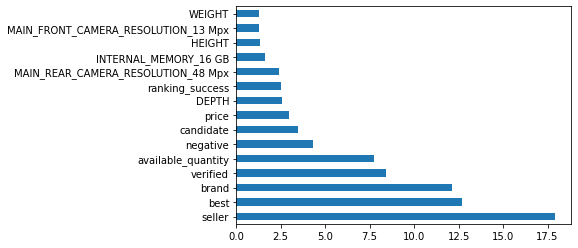

In [336]:
feat_importances = pd.Series(cbr.best_estimator_.get_feature_importance(), index=X_test.columns)
feat_importances.nlargest(15).plot(kind='barh')

Algo que se puede percibir en primera instancia es que en el test score esta siendo superior al train score.
El data set es pequeño comparado con el caso anterior donde se incorporo un mayor numero de registros. Tambien, habria que revisar como es la distribucion de los datos que pueda explicar este comportamiento observado.

Por otro lado, juega en contra la maldicion de la dimensionalidad, ya que el número de columnas es casi del mismo orden que el numero de registros, posibllemente necesito mucha más data.

In [280]:
# para conservarlo
data_cell_att.to_excel('./data/data_cell_att.xlsx', index= False)
data_cell_att_minus.to_excel('./data/data_cell_att_minus.xlsx', index= False)
data_cell_att_minus[atributos_seleccionados].to_excel('./data/data_cell_att_minus2.xlsx', index= False)

In [162]:
#pip freeze > requirements.txt